In [765]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import eos_integrate
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", dpi=144)
import scipy.optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exploring $\alpha$-$\beta$ space

We have a pulsar of known mass (${\sim}1.43 M_\odot$) and for each $\alpha_0$, $\beta_0$ we want to compute $\alpha_A$ and determine whether $\alpha_0(\alpha_A-\alpha_0)<\Delta_{max}$. But when we integrate an EOS we supply the central pressure, scalar value, and $\beta_0$, and we get out $\alpha_0$, $m_A$, and $\alpha_A$. So we have some root-finding to do. 
* Option 1: Use 2D root-finding to compute the right $\alpha_0$ for each $\beta_0$.
* Option 2: Build a database of pulsars on a grid of pressure, scalar value, and $\beta_0$. Then use interpolation to draw limit curves.
* Option 3: Use 1D root finding on the mass, then explore phi_0 values

Note that we have to do this for several different pulsar masses and constraint levels; at least 0348, 1738, and 0337. So Option 2 has some appeal. Particularly as we're not yet quite sure what our limit will be.

In [107]:
def f(x, beta_0):
    lp_c, lphi_c = x
    p_c = np.exp(lp_c)
    phi_c = np.exp(lphi_c)
    print(p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    res = np.array([m_A-1.43, alpha_0*(alpha_A-alpha_0)-1.6e-6])
    print(res)
    return res

r = scipy.optimize.root(
    f, 
    [np.log(0.76e15), np.log(1e-3)],
    args=(-3,),
    method="lm")

7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6000038804e+14 0.001 -3
[ -1.42930227e+00  -1.60000028e-06]
7.6e+14 0.00100000010293 -3
[ -1.42930227e+00  -1.60000028e-06]
inf 0.0 -3
[ nan  nan]
inf 0.0 -3
[ nan  nan]
4.47742327279e+74 0.0 -3
[ nan  nan]
1.37180624906e+21 0.0 -3
[ -1.29965404e+00  -1.60000000e-06]
1.37180724396e+21 0.0 -3
[ -1.29965401e+00  -1.60000000e-06]
1.37180624906e+21 0.0 -3
[ -1.29965404e+00  -1.60000000e-06]
1.72524033237e+21 0.0 -3


/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
eos_integrate.py:230: RuntimeWarning: invalid value encountered in double_scalars
  * a_phi*(e-3*p_c))
eos_integrate.py:203: RuntimeWarning: invalid value encountered in double_scalars
  * (a_phi*(e-3*p)+rho*psi*(e-p))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Illegal input detected. (See printed message.)
  'Unexpected istate=%s' % istate))
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/scipy/integrate/_ode.py:869: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  'Unexpected istate=%s' % istate))
eos_integrate.py:243: RuntimeWarning: invalid value encountered in double_scalars
  self.alpha_A = 2*phi/

[ -1.28990959e+00  -1.60000000e-06]
1.72524158948e+21 0.0 -3
[ -1.28990956e+00  -1.60000000e-06]
1.72524033237e+21 0.0 -3
[ -1.28990959e+00  -1.60000000e-06]
2.70984727378e+21 0.0 -3
[ -1.26905736e+00  -1.60000000e-06]
2.70984926657e+21 0.0 -3
[ -1.26905732e+00  -1.60000000e-06]
2.70984727378e+21 0.0 -3
[ -1.26905736e+00  -1.60000000e-06]
6.34411225377e+21 0.0 -3
[ -1.22263520e+00  -1.60000000e-06]
6.34411699958e+21 0.0 -3
[ -1.22263514e+00  -1.60000000e-06]
6.34411225377e+21 0.0 -3
[ -1.22263520e+00  -1.60000000e-06]
1.86472499194e+22 0.0 -3
[ -1.15010421e+00  -1.60000000e-06]
1.86472641683e+22 0.0 -3
[ -1.15010415e+00  -1.60000000e-06]
1.86472499194e+22 0.0 -3
[ -1.15010421e+00  -1.60000000e-06]
1.4832230834e+23 0.0 -3
[ -9.65739504e-01  -1.60000000e-06]
1.48322426261e+23 0.0 -3
[ -9.65739347e-01  -1.60000000e-06]
1.4832230834e+23 0.0 -3
[ -9.65739504e-01  -1.60000000e-06]
7.19237449692e+23 0.0 -3
[ -8.08276594e-01  -1.60000000e-06]
7.19238038429e+23 0.0 -3
[ -8.08276948e-01  -1.6000

In [114]:
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

r = scipy.optimize.brentq(
    f, 
    0.1e15,1.7e15,
    args=(1e-3,-3))

In [115]:
r

553380926715902.0

In [ ]:
solutions = set()

In [124]:
last = None
def f(rho_c, phi_c, beta_0):
    p_c = eos_integrate.lookup(
        eos_integrate.table_merged[:,1],
        eos_integrate.table_merged[:,2],
        rho_c)

    # print(rho_c, p_c, phi_c, beta_0)
    d = eos_integrate.evaluate(p_c, phi_c, beta_0)
    m_A = d["m_A"]
    alpha_0 = d["alpha_0"]
    alpha_A = d["alpha_A"]
    # print(m_A, d["R"])
    res = m_A-1.43
    # print("alpha_0\t", alpha_0)
    # print("alpha_A\t", alpha_A)
    # print("R\t",res, alpha_0*(alpha_A-alpha_0))
    return res

def g(phi_c, beta_0):
    rho_c = scipy.optimize.brentq(
        f, 
        0.1e15,1.7e15,
        args=(phi_c,beta_0))
    d = eos_integrate.evaluate(rho_c, phi_c, beta_0)
    global last
    last = (rho_c, phi_c, beta_0)
    print(last, d["Delta"])
    return np.abs(d["Delta"]) - 4e-7

xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),100))
ys = []
for phi_c in xs:
    ys.append(g(phi_c,-3))

#phi_c = scipy.optimize.brentq(
#    g, 
#    0.1e-3,0.5,
#    args=(-3,))

#d = eos_integrate.evaluate(*last)
#d

(553380926882925.6, 0.0010000000000000002, -3) -1.49283119058e-12
(553381016890000.9, 0.00106478597782335, -3) -1.69253215601e-12
(553381100546195.8, 0.0011337691785692262, -3) -1.91894866798e-12
(553381221689049.5, 0.0012072215234288095, -3) -2.17565501475e-12
(553381347852073.7, 0.0012854325502735374, -3) -2.46670364015e-12
(553381497802855.7, 0.0013687105549689707, -3) -2.79668931853e-12
(553381688203902.44, 0.0014573838066297739, -3) -3.17082161428e-12
(553381853537977.25, 0.0015518018416061992, -3) -3.59500756245e-12
(553382034596566.2, 0.0016523368413027301, -3) -4.07594466688e-12
(553382240303320.4, 0.0017593850992600724, -3) -4.62122625405e-12
(553382458606341.6, 0.0018733685832834674, -3) -5.23946310646e-12
(553382723823358.2, 0.0019947365987750282, -3) -5.9404176523e-12
(553383027887903.4, 0.0021239675598266911, -3) -6.73516011469e-12
(553383372472591.56, 0.0022615708750551352, -3) -7.63624236397e-12
(553383767164943.1, 0.0024080889556123909, -3) -8.65789727913e-12
(553384232

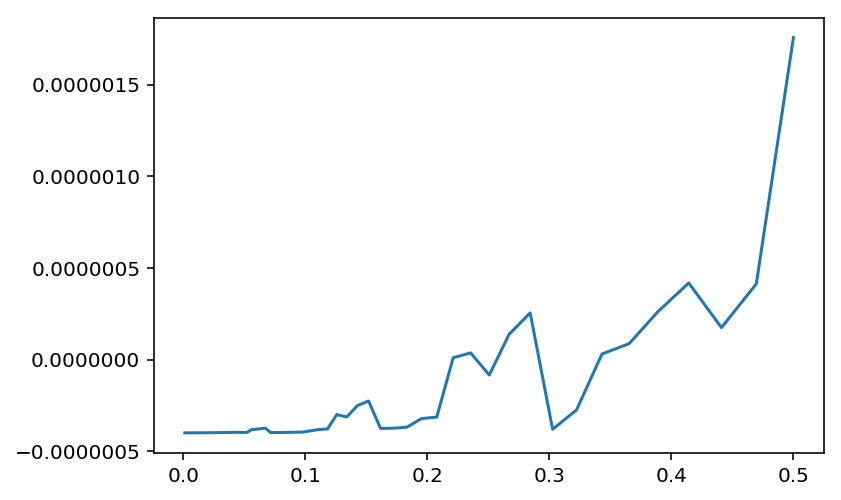

In [125]:
plt.plot(xs, ys)

In [128]:
l = []

In [129]:
l.insert?

In [170]:
points = []

In [171]:
eos_integrate.mr_curve(points, 0, 0, 1.43)

{'Delta': 0.0,
 'I_A': 2.2530921759394333e+36,
 'J_A': 2.2530921806348049e+36,
 'Omega': 1.0000000020839679,
 'Q1': 1.0,
 'Q2': 0.83131792872211197,
 'R': 13.652707150389318,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (6.204500705854884e+34, 0, 0),
 'm_A': 1.4299999999090507,
 'mb_A': 1.5663402707884728,
 'nu_hat': -0.369485943174853,
 'nu_prime': 3.2740070019246783e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [172]:
len(points)

103

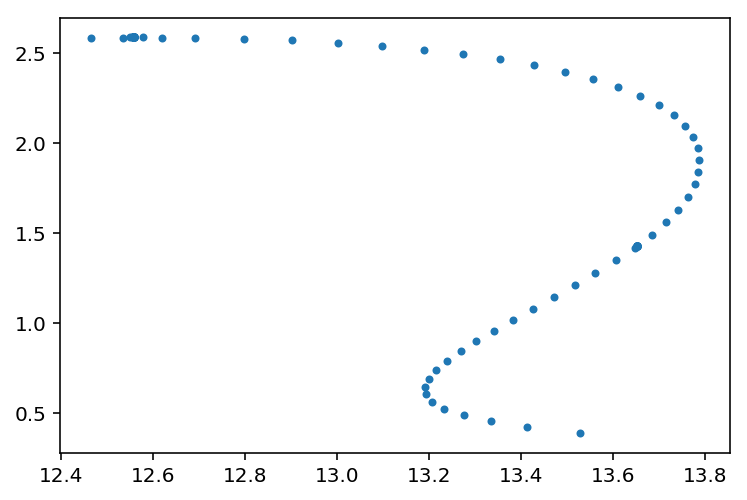

In [173]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")

In [177]:
eos_integrate.mr_curve(points, 0, 0, 2.0)

{'Delta': 0.0,
 'I_A': -4.846746127815239e+38,
 'J_A': -4.8467456783196633e+38,
 'Omega': 0.99999990725827925,
 'Q1': 1.0,
 'Q2': 0.75627353053489899,
 'R': 13.780042337385396,
 'a': 0,
 'alpha_0': 0.0,
 'alpha_A': 0.0,
 'b': 0,
 'beta_0': 0,
 'initial': (1.3668680456297637e+35, 0, 0),
 'm_A': 2.0000000001226454,
 'mb_A': 2.2859172117225328,
 'nu_hat': -0.55870431072849713,
 'nu_prime': 5.4310837607406777e-07,
 'phi_0': 0.0,
 'rho_start': 1e-06}

In [178]:
len(points)

114

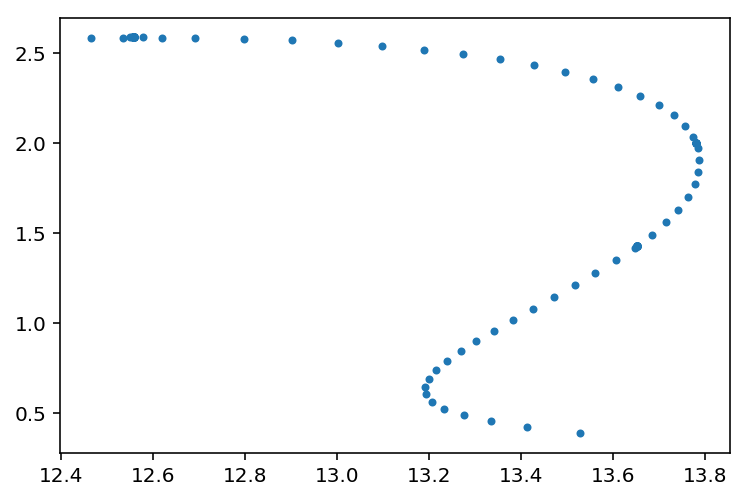

In [179]:
plt.plot([d["R"] for p_c,d in points],
         [d["m_A"] for p_c,d in points],
         ".")

In [183]:
alpha_map = {}

In [202]:
xs = np.exp(np.linspace(np.log(1e-3),np.log(0.5),10))
ys = []
for phi_c in xs:
    if phi_c not in alpha_map:
        alpha_map[phi_c] = []
    try:
        d = eos_integrate.mr_curve(alpha_map[phi_c], phi_c, -3, 1.43)
        ys.append(d)
        print(phi_c, d["Delta"])
    except FloatingPointError:
        pass

0.001 8.2435011682e-07
0.00199473659878 3.28004531139e-06
0.00397897409849 1.30508657302e-05
0.00793700525984 5.19233127008e-05
0.0158322348765 0.00020651349518
0.0315811383485 0.000820311314733
0.0629960524947 0.00324128964833
0.12566053149 0.0125039170587


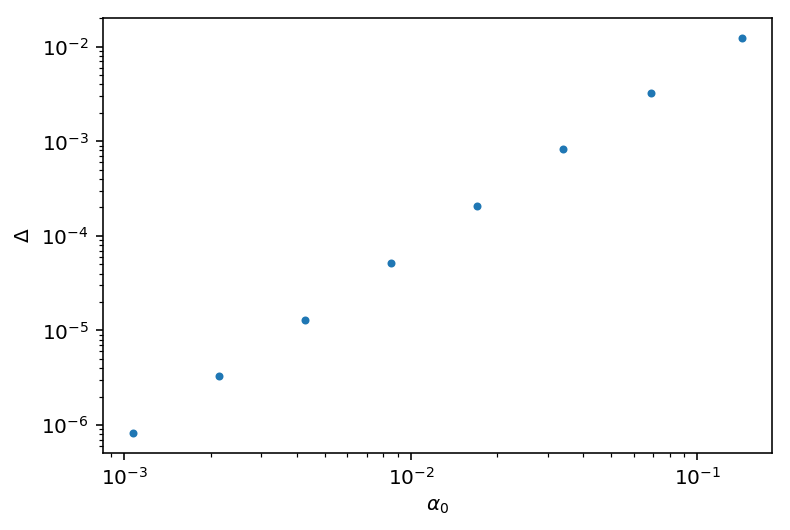

In [203]:
plt.loglog([abs(y["alpha_0"]) for y in ys], 
           [y["Delta"] for y in ys], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\Delta$")

In [218]:
eos_integrate.explore_alpha(alpha_map, -3, 1.43, 
                            lambda d: abs(d["Delta"])-4e-7)

-3.92253382223e-15 -4e-07
Starting search
-3.92253382223e-15 -4e-07
2.14776929889e-15 -4e-07
0.0005 -1.93912083162e-07
0.000656820264279 -4.43642432244e-08
0.000696515524637 -7.93076999112e-11
0.00069658446682 -1.35522257923e-13
0.000696584520726 -6.00005822881e-14
0.000696584572769 -3.92253382223e-15
0.000696584574632 2.14776929889e-15
Brackting done 0.000696584572769 0.000696584574632
0.000696584572769 -3.92253382223e-15
0.000696584574632 2.14776929889e-15
0.000696584572769 -3.92253382223e-15
0.000696584574632 2.14776929889e-15


0.0006965845746315687

In [219]:
all_map = {}


In [650]:
betas = np.linspace(-6,6,40)
eos_integrate.explore_beta(all_map, betas, mass_0337, 
                           condition_0337)

Exploring for beta=-6.000000
0.0001 7.3791947018e-05
0.0001 7.3791947018e-05
0.0001 7.3791947018e-05
brentq with 0.0001 -7.3791947018e-05 1 inf
0.0001 7.3791947018e-05
0.0001000000005 7.37919469712e-05
0.50005 -1.72413708044
0.00012139661995 8.95809162483e-05
0.25008569831 -0.174793103157
0.000249436919042 0.000184064044819
0.125167567615 0.0466282919127
0.187626632962 -0.016240133328
0.171492245233 0.00835024690635
0.176971059303 0.000706122819012
0.177456074006 -4.50291759188e-06
0.177453000685 2.16114691143e-08
0.177453015364 2.16957535271e-10
0.177453015513 -7.69595220884e-11
0.177453015474 2.12569961633e-11
0.177453015483 -1.99636973619e-11
0.177453015479 -8.71661076651e-12
0.177453015476 5.8079374643e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
0.177453015478 condition: -1.59999891143e-06
0.177453015478 condition: -1.59999891143e-06
0.177456074006 condition: 8.38528197695e-07
0.177453015483 condition: -1.59998918887e-06
0.177453015513 condition: -1.59995

0.000332510856104 condition: -1.4731743793e-06
0.00307889861347 condition: 9.27433010321e-06
0.000708961788165 condition: -1.02344375517e-06
0.00148050293976 condition: 9.14302533907e-07
0.0011164604261 condition: -1.70171341073e-07
0.0011735845341 condition: -2.01119564565e-08
0.00118107589896 condition: 1.22375794138e-10
0.00118103059172 condition: -3.88098838929e-13
0.00118103559172 condition: 1.31599495957e-11
Exploring for beta=-3.538462
0.0001 -9.14850139783e-05
0 condition: -1.6e-06
0 condition: -1.6e-06
0.0001 condition: -1.58915784922e-06
0.0001 condition: -1.58915784922e-06
brentq with 0.0001 -1.58915784922e-06 1 inf
0.0001 condition: -1.58915784922e-06
0.000100005 condition: -1.58915676498e-06
0.5000500025 condition: 0.0360544686466
0.000122040102257 condition: -1.58385193196e-06
0.00670072147865 condition: 4.7083298586e-05
0.000336140519003 condition: -1.47749403763e-06
0.00321987077115 condition: 9.64080202807e-06
0.000719355197627 condition: -1.03894884512e-06
0.001538902

0.0001 -8.05488987328e-05
1 -0.945962595829
0 condition: -1.6e-06
1 condition: 0.0980861686184
0 condition: -1.6e-06
1 condition: 0.0980861686184
0.0001 condition: -1.59942576012e-06
0.0001 condition: -1.59942576012e-06
1 condition: 0.0980861686184
brentq with 0.0001 -1.59942576012e-06 1 0.0980861686184
0.0001 condition: -1.59942576012e-06
1.0 condition: 0.0980861686184
0.000116304436827 condition: -1.59922324167e-06
0.128865115031 condition: 0.000966276383909
0.000329036412629 condition: -1.59378299361e-06
0.0625486802827 condition: 0.00022385106476
0.000768898362266 condition: -1.56605065099e-06
0.0254354204058 condition: 3.55726783349e-05
0.00180902611996 condition: -1.41207510775e-06
0.0109836142371 condition: 5.32837065234e-06
0.00373103661676 condition: -8.00611545178e-07
0.00591886417837 condition: 4.11795290171e-07
0.00517576618576 condition: -6.16572374697e-08
0.0052725390758 condition: -3.592081876e-09
0.00527847396246 condition: 4.02333013901e-12
0.00527846732249 condition: 

0.001454234273 condition: -1.1000511176e-11
Exploring for beta=1.384615
0.0001 0.000188466228554
1 0.631705685272
0 condition: -1.6e-06
1 condition: 0.362945419527
0 condition: -1.6e-06
1 condition: 0.362945419527
0.0001 condition: -1.58480967236e-06
0.0001 condition: -1.58480967236e-06
1 condition: 0.362945419527
brentq with 0.0001 -1.58480967236e-06 1 0.362945419527
0.0001 condition: -1.58480967236e-06
1.0 condition: 0.362945419527
0.000104366067697 condition: -1.58345427569e-06
0.0052050414347 condition: 3.95566977705e-05
0.000300687321194 condition: -1.46265987198e-06
0.0025931117342 condition: 8.6144690994e-06
0.000633424672078 condition: -9.90522821741e-07
0.0012595041552 condition: 8.09726785627e-07
0.00097790246767 condition: -1.47356316894e-07
0.00102125898227 condition: -1.56910583773e-08
0.00102632772276 condition: 7.45739341619e-11
0.00102630374682 condition: -1.83931911712e-13
0.00102630874682 condition: 1.54064328777e-11
Exploring for beta=1.692308
0.0001 0.00024493634618

0.000100363679726 condition: -9.39741734401e-07
0.000171916810899 condition: 3.37302470835e-07
0.000153017662505 condition: -6.52280531024e-08
0.000156080174741 condition: -3.17908249455e-09
0.000156235617675 condition: 3.10459785453e-12
0.000156230617675 condition: -9.9303409509e-11
Exploring for beta=4.769231
0.0001 0.00116314987009
1 1.81590918201
0 condition: -1.6e-06
1 condition: 2.84300903776
0 condition: -1.6e-06
1 condition: 2.84300903776
0.0001 condition: -7.62308563277e-07
0.0001 condition: -7.62308563277e-07
1 condition: 2.84300903776
brentq with 0.0001 -7.62308563277e-07 1 2.84300903776
0.0001 condition: -7.62308563277e-07
1.0 condition: 2.84300903776
0.000100268107529 condition: -7.5781071415e-07
0.000145439632433 condition: 1.7194253043e-07
0.000137085903806 condition: -2.57645449076e-08
0.00013817453463 condition: -6.62536346567e-10
0.000138203157398 condition: 1.35706909518e-13
0.000138198157398 condition: -1.15633715753e-10
Exploring for beta=5.076923
0.0001 0.00129553

array([ -5.41545350e-01,  -4.39729663e-01,  -2.98755547e-01,
        -1.02249998e-02,  -4.21684130e-03,  -3.26284366e-03,
        -2.85499028e-03,  -2.64839729e-03,  -2.55103595e-03,
        -2.53165473e-03,  -2.58437981e-03,  -2.72344892e-03,
        -2.99631815e-03,  -3.54736156e-03,  -5.05541578e-03,
        -1.02128095e-02,  -3.87546264e-03,  -2.75397014e-03,
        -2.20686850e-03,  -1.86678951e-03,   1.62918992e-03,
         1.45162979e-03,   1.31261643e-03,   1.20019761e-03,
         1.10703653e-03,   1.02834759e-03,   9.60854800e-04,
         9.02230136e-04,   8.50764986e-04,   8.05185708e-04,
         7.64494004e-04,   7.27929880e-04,   6.94857034e-04,
         6.64810273e-04,   6.37356111e-04,   6.12181467e-04,
         5.89013510e-04,   5.67586095e-04,   5.47734026e-04,
         5.29269231e-04])

In [673]:
betas = sorted(all_map.keys())
ds = [eos_integrate.explore_alpha(all_map[beta], beta, mass_0337,
                                      condition_0337)
          for beta in betas]
alphas = np.array([d["alpha_0"] for d in ds])


0.0001 7.3791947018e-05
0.0001 7.3791947018e-05
0.177453015476 5.8079374643e-12
0.182359581327 -0.00751454650386
0.177455017226 -2.95368690914e-06
0.177453015479 -8.71661076651e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
brentq with 0.177453015477 -1.38122846494e-11 0.177453015478 2.01014205281e-12
0.177453015477 1.38122846494e-11
0.177453015478 -2.01014205281e-12
0.177453015478 condition: -1.59999891143e-06
0.177453015478 condition: -1.59999891143e-06
0.182359581328 condition: 0.0041228703216
0.177456074006 condition: 8.38528197695e-07
0.177453015513 condition: -1.59995832339e-06
0.177455017226 condition: -4.53313960034e-10
0.177455022275 condition: 4.01584514901e-09
0.177455017226 condition: -4.53313960034e-10
0.177455022275 condition: 4.01584514901e-09
brentq with 0.177455017226 -4.53313960034e-10 0.177455022275 4.01584514901e-09
0.177455017226 condition: -4.53313960034e-10
0.177455022275 c

0.00234485762723 condition: 2.90314360033e-06
0.00139771141635 condition: 2.21261282726e-12
0.00139770641635 condition: -9.23472930705e-12
0.00139771141635 condition: 2.21261282726e-12
brentq with 0.00139770641635 -9.23472930705e-12 0.00139771141635 2.21261282726e-12
0.00139770641635 condition: -9.23472930705e-12
0.00139771141635 condition: 2.21261282726e-12
0.0001 -0.000108208965014
1 -2.65184807052
0 condition: -1.6e-06
1 condition: 0.965016793446
0 condition: -1.6e-06
1 condition: 0.965016793446
0.00143818350381 condition: -9.60623006504e-11
0.00147789317134 condition: 8.94731053678e-08
0.00143822168073 condition: -1.11220525835e-11
0.00143822668073 condition: 2.69184042495e-15
0.00143822168073 condition: -1.11220525835e-11
0.00143822668073 condition: 2.69184042495e-15
brentq with 0.00143822168073 -1.11220525835e-11 0.00143822668073 2.69184042495e-15
0.00143822168073 condition: -1.11220525835e-11
0.00143822668073 condition: 2.69184042495e-15
0.0001 -0.000112098200723
1 -2.3484701134

0.00424116573669 condition: -5.76537817805e-10
0.00750091945429 condition: 3.40301719209e-06
0.00424193019284 condition: 9.69305217332e-14
0.00424192519284 condition: -3.67482897377e-12
0.00424192519284 condition: -3.67482897377e-12
0.00424193019284 condition: 9.69305217332e-14
brentq with 0.00424192519284 -3.67482897377e-12 0.00424193019284 9.69305217332e-14
0.00424192519284 condition: -3.67482897377e-12
0.00424193019284 condition: 9.69305217332e-14
0.0001 6.97924631568e-05
1 0.640796605212
0 condition: -1.6e-06
1 condition: 0.321652662898
0 condition: -1.6e-06
1 condition: 0.321652662898
0.0144956994646 condition: 3.44057803124e-05
0.00305597010143 condition: 1.76850062025e-12
0.00170607220105 condition: -1.10132823694e-06
0.00305505207466 condition: -9.59389817843e-10
0.00305596510143 condition: -3.46750809163e-12
0.00305596510143 condition: -3.46750809163e-12
0.00305597010143 condition: 1.76850062025e-12
brentq with 0.00305596510143 -3.46750809163e-12 0.00305597010143 1.76850062025

0.000173672770992 condition: -8.36250315818e-11
0.000173677770992 condition: 8.49876937963e-12
0.0001 0.00103888999029
1 1.73866241745
0 condition: -1.6e-06
1 condition: 2.59685446302
0 condition: -1.6e-06
1 condition: 2.59685446302
0.000156080174741 condition: -3.17908249455e-09
0.000156235617675 condition: 3.10459785453e-12
0.000156230617675 condition: -9.9303409509e-11
0.000156230617675 condition: -9.9303409509e-11
0.000156235617675 condition: 3.10459785453e-12
brentq with 0.000156230617675 -9.9303409509e-11 0.000156235617675 3.10459785453e-12
0.000156230617675 condition: -9.9303409509e-11
0.000156235617675 condition: 3.10459785453e-12
0.0001 0.00116314987009
1 1.81590918201
0 condition: -1.6e-06
1 condition: 2.84300903776
0 condition: -1.6e-06
1 condition: 2.84300903776
0.00013817453463 condition: -6.62536346567e-10
0.000138203157398 condition: 1.35706909518e-13
0.000138198157398 condition: -1.15633715753e-10
0.000138198157398 condition: -1.15633715753e-10
0.000138203157398 conditi

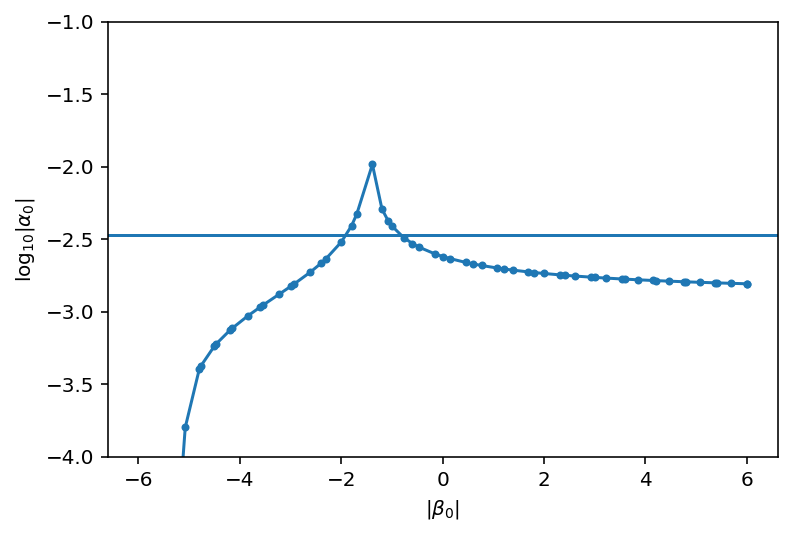

In [676]:
plt.plot(betas, np.log10(np.abs(alphas)), ".-")
plt.xlabel(r"$|\beta_0|$")
plt.ylabel(r"$\log_{10}|\alpha_0|$")
plt.ylim(-4,-1)
cassini_limit = 3.4e-3
plt.axhline(np.log10(cassini_limit))

plt.savefig("alpha-beta-0337-ska.pdf")

## Checking the calculation of $\alpha_0$

In [272]:
mass = 1.43
phi_c = 0.001
beta = -1
points = []

d = eos_integrate.mr_curve(points, phi_c, beta, mass) 

In [273]:
d["alpha_0"], d["phi_0"], d["alpha_A"]

(-0.00076589550443647647, 0.00076589550443647647, -0.00068632362755137867)

In [274]:
N = eos_integrate.NeutronStar(a = d["alpha_0"], b = d["beta_0"])
N.integrate(d["initial"][0], d["initial"][1]-d["phi_0"])
N.alpha_0, N.phi_0, N.alpha_A

(-0.00076589553916621802, 3.4729741516447907e-11, -0.00068632371175226137)

In [275]:
N.Delta

-6.0943707659653578e-08

## LLR constraint

Lunar laser ranging provides a constraint on $\alpha_0$ and $\beta_0$. It comes in the weak-field regime, where we are at 1PN order even inside the bodies. We can therefore write it in terms of the Eddington parameters:
$$
\bar \gamma \equiv \gamma_{Edd} - 1 = -2\alpha_0^2/(1+\alpha_0^2)
$$
and
$$
\bar \beta \equiv \beta_{Edd} - 1 = \frac{1}{2}\beta_0\alpha_0^2/(1+\alpha_0^2)^2.
$$
The LLR constraint is 
$$
|\eta_N| < 10^{-3}
$$
and we have, in these Lorentz-invariant theories,
$$
\eta_N = 4\beta_{Edd}-\gamma_{Edd}-3.
$$
Rewriting, we get
$$
\left| 2\beta_0\alpha_0^2/(1+\alpha_0^2)^2 + 2\alpha_0^2/(1+\alpha_0^2) \right| < 10^{-3}
$$
or
$$
\left| \frac{2\alpha_0^2}{(1+\alpha_0^2)^2}(\beta_0+1+\alpha_0^2) \right| < 10^{-3}
$$

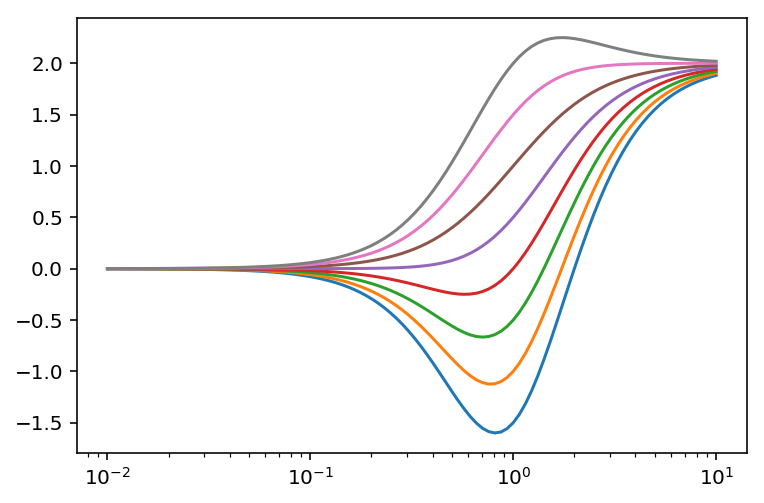

In [952]:
def llrrhs(asq, beta_0):
    return 2*asq*(beta_0+1+asq)/(1+asq)**2

alphas = np.exp(np.linspace(np.log(1e-2),np.log(10),100))
for beta_0 in [-5,-4,-3,-2,-1,0,1,2]:
    plt.semilogx(alphas, llrrhs(alphas**2, beta_0))

Root-finding is going to be annoying, so let's try this the high-school way. Let $a=\alpha_0^2$, $b=\beta_0^2$ and $l=\pm 10^{-3}$. Then we want to find
$$
2a(b+1+a)=l(1+a)^2
$$
or
$$
(2-l)a^2 + 2(b+1-l)a - l = 0
$$
to which the solutions are
$$
-\frac{(b+1-l)\pm\sqrt{(b+1-l)^2+l(2-l)}}{2-l}
$$

/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/users/aarchiba/.virtualenvs/triplesystem/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


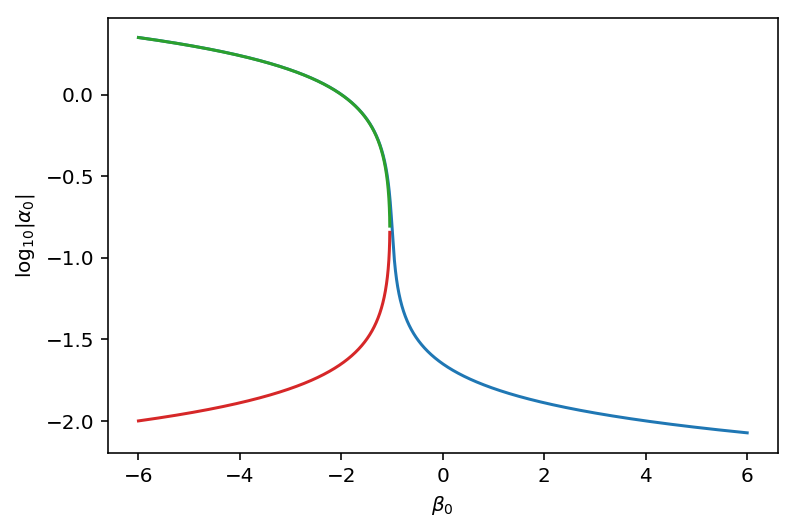

In [961]:
def llr_sol(b, l, sgn):
    return np.sqrt((-(b+1-l)+sgn*np.sqrt((b+1-l)**2+l*(2-l)))
            /(2-l))
betas_llr = np.linspace(-6,6,10000)
alphas_llr = []
for l, sgn in [(1e-3,1),(1e-3,-1),(-1e-3,1),(-1e-3,-1)]:
    a = llr_sol(betas_llr, l, sgn)
    a[a<0] = np.inf
    alphas_llr.append(a)
    plt.plot(betas_llr, np.log10(a))
plt.xlabel(r"$\beta_0$")
plt.ylabel(r"$\log_{10}|\alpha_0|$")


## Multiple constraints

In [785]:
nscn = "ns_cache.pickle"
if os.path.exists(nscn):
    ns_cache = pickle.load(open(nscn,"rb"))
    print(len(ns_cache))
all_map_new = {}
for (p_c, phi_c, beta_0), d in ns_cache.items():
    if beta_0 not in all_map_new:
        all_map_new[beta_0] = {}
    alpha_map = all_map_new[beta_0]
    if phi_c not in alpha_map:
        alpha_map[phi_c] = []
    mr_curve = alpha_map[phi_c]
    mr_curve.append((p_c, d))
    mr_curve.sort()
all_map = all_map_new

435072


In [930]:
betas = np.linspace(-6, 6.01, 81) # can't have beta=0
betas = np.unique(np.concatenate(  # unique also sorts
    [betas, 
     np.linspace(-2, -1, 11),
     np.linspace(-1.6, -1.3, 11),
     np.linspace(-1.5, -1.4, 11),
     np.linspace(-1.46, -1.42, 11),
     np.linspace(-1.445, -1.440, 11),
     np.linspace(-1.450, -1.445, 11),
    ]))


In [931]:
llr_betas = betas
llr_delta = 1e-3
# FIXME: 1738 paper shows this as an upper limit with a funny shape
# how to get alpha_A for Earth Moon and Sun?

In [932]:
cassini_limit = 3.4e-3
alphas_cassini = cassini_limit*np.ones_like(betas)

In [933]:
def condition_0348(d):
    return (np.abs(d["alpha_A"] - d["alpha_0"]) - 0.005)
mass_0348 = 2.0
alphas_0348 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_0348,
                                         condition_0348)

Exploring for beta=-6.000000
1e-06 1.5408761239e-06
1 -5.81694304579
1e-06 1.5408761239e-06
1 -5.81694304579
0.177453015476 0.13798278268
0.182359580757 0.133929178106
0.25008569831 0.0100656583167
0.253601483935 -2.186584247e-13
0.253601216775 7.79137713014e-07
0.253601483934 1.51861856423e-12
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
brentq with 0.253601483934 -1.51861856423e-12 0.253601483935 2.186584247e-13 xtol 1e-12
0.253601483934 1.51861856423e-12
0.253601483935 -2.186584247e-13
phi_c_0 0.253601483935
0.253601483935 0 condition: 0.642814993224
No solution
Exploring for beta=-5.849875
1e-06 1.37568480472e-06
1 -5.65733944223
1e-06 1.37568480472e-06
1 -5.65733944223
0.164806876517 0.124473698105
0.170271083439 0.12141951536
0.246701756797 1.66544017022e-10
0.246701756824 -8.71322755648e-11
0.246701756804 -2.17418206185e-08
0.246701756798 -2.17859409948e-08
0.246701756797 1.66544017022e-10
0.246701756798 -2.17859409948e-08
brentq with 0.246701756797 -1.665440

1 -3.74406544632
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.585035565051
0 0 condition: -0.005
1 1 condition: 0.585035565051
0.00314187015361 0.00314187015361 condition: 4.62640126816e-09
0.00114384077867 0.00114384077867 condition: -0.00317960435886
0.00118661591567 0.00118661591567 condition: -0.00311152965342
0.00314186724622 0.00314186724622 condition: -9.8745664423e-14
0.00314186724672 0.00314186724672 condition: 6.82132302032e-13
0.00314186724622 0.00314186724622 condition: -9.8745664423e-14
0.00314186724672 0.00314186724672 condition: 6.82132302032e-13
brentq with 0.00314186724622 -9.8745664423e-14 0.00314186724672 6.82132302032e-13 xtol 1e-12
0.00314186724622 0.00314186724622 condition: -9.8745664423e-14
0.00314186724672 0.00314186724672 condition: 6.82132302032e-13
returning 0.00314186724622 -0.000768238387571 -9.8745664423e-14
Exploring for beta=-3.898250
1e-06 -3.43547027508e-07
1 -3.58682320646
No spontaneous scalarization found
0 0 condition:

1 -2.3670051753
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.376749496567
0 0 condition: -0.005
1 1 condition: 0.376749496567
0.013097419891 0.013097419891 condition: 0.000879303771945
0.00199059724276 0.00199059724276 condition: -0.00410587142069
0.00318456086214 0.00318456086214 condition: -0.00356960542328
0.0111365722115 0.0111365722115 condition: -4.46283635047e-14
0.011136572212 0.011136572212 condition: 7.26588060551e-13
0.0111365722115 0.0111365722115 condition: -4.46283635047e-14
0.011136572212 0.011136572212 condition: 7.26588060551e-13
brentq with 0.0111365722115 -4.46283635047e-14 0.011136572212 7.26588060551e-13 xtol 1e-12
0.0111365722115 0.0111365722115 condition: -4.46283635047e-14
0.011136572212 0.011136572212 condition: 7.26588060551e-13
returning 0.0111365722115 -0.00987672566983 -4.46283635047e-14
Exploring for beta=-2.547125
1e-06 -9.19874104107e-07
1 -2.22135405832
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 

1 -1.52572814136
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.217491187311
0 0 condition: -0.005
1 1 condition: 0.217491187311
0.244304514302 0.244304514302 condition: -1.40526502761e-10
0.24771154368 0.24771154368 condition: 0.000157810214176
0.244304517418 0.244304517418 condition: 1.260745848e-12
0.244304517321 0.244304517321 condition: -3.74780328299e-12
0.244304517321 0.244304517321 condition: 1.49384844772e-13
0.244304517321 0.244304517321 condition: -3.74780328299e-12
0.244304517321 0.244304517321 condition: 1.49384844772e-13
brentq with 0.244304517321 -3.74780328299e-12 0.244304517321 1.49384844772e-13 xtol 1e-12
0.244304517321 0.244304517321 condition: -3.74780328299e-12
0.244304517321 0.244304517321 condition: 1.49384844772e-13
returning 0.244304517321 -0.244695208093 1.49384844772e-13
Exploring for beta=-1.700000
1e-06 -9.43099114972e-07
1 -1.44066158392
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.202670022177
0 0 co

1 -1.25909444076
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.173112212833
0 0 condition: -0.005
1 1 condition: 0.173112212833
0.0475506515225 0.0475506515225 condition: 2.06984603068e-13
0.011243490791 0.011243490791 condition: -0.00381309064391
0.0163272608458 0.0163272608458 condition: -0.00327687727507
0.0475506511459 0.0475506511459 condition: -3.87923677556e-11
0.0475506515206 0.0475506515206 condition: -8.43032241238e-14
0.0475506515217 0.0475506515217 condition: -3.00380380291e-13
0.0475506515217 0.0475506515217 condition: -3.00380380291e-13
0.0475506515225 0.0475506515225 condition: 2.06984603068e-13
brentq with 0.0475506515217 -3.00380380291e-13 0.0475506515225 2.06984603068e-13 xtol 1e-12
0.0475506515217 0.0475506515217 condition: -3.00380380291e-13
0.0475506515225 0.0475506515225 condition: 2.06984603068e-13
returning 0.0475506515225 -0.0429481101137 2.06984603068e-13
Exploring for beta=-1.480000
1e-06 -8.99879121625e-07
1 -1.25056746759
No spon

0.0433484857055 0.0433484857055 condition: -2.59961082095e-05
0.043575124525 0.043575124525 condition: -1.51943413881e-07
0.0435764569111 0.0435764569111 condition: -1.07726809244e-10
0.0435764578565 0.0435764578565 condition: 3.78854066174e-13
0.0435764578532 0.0435764578532 condition: -1.90211561779e-13
0.0435764578543 0.0435764578543 condition: 3.18471811422e-13
0.0435764578537 0.0435764578537 condition: 1.81407840139e-13
returning 0.0435764578537 -0.0389079770593 1.81407840139e-13
Exploring for beta=-1.449000
1e-06 -8.92051590875e-07
1 -1.22420065517
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.167817832608
0 0 condition: -0.005
1 1 condition: 0.167817832608
1e-06 1e-06 condition: -0.00499988474495
1e-06 1e-06 condition: -0.00499988474495
1 1 condition: 0.167817832608
brentq with 1e-06 -0.00499988474495 1 0.167817832608 xtol 1e-12
1e-06 1e-06 condition: -0.00499988474495
1.0 1.0 condition: 0.167817832608
0.0289325228882 0.0289325228882 condition: -0.001

1 1 condition: 0.167373514643
brentq with 1e-06 -0.00499988395011 1 0.167373514643 xtol 1e-12
1e-06 1e-06 condition: -0.00499988395011
1.0 1.0 condition: 0.167373514643
0.0290070936956 0.0290070936956 condition: -0.00163897489571
0.0430149837144 0.0430149837144 condition: -2.50258843082e-05
0.0432314710342 0.0432314710342 condition: -1.60418487267e-07
0.0432328676212 0.0432328676212 condition: 1.28319412387e-11
0.0432328675094 0.0432328675094 condition: 1.92399048082e-13
0.0432328675077 0.0432328675077 condition: 1.41092866557e-13
0.0432328675031 0.0432328675031 condition: -3.66633806648e-15
0.0432328675036 0.0432328675036 condition: -2.17405086989e-13
0.0432328675061 0.0432328675061 condition: 5.70698002744e-14
0.0432328675048 0.0432328675048 condition: -6.01264697753e-13
0.0432328675056 0.0432328675056 condition: -5.34075388081e-13
returning 0.0432328675061 -0.0385554611422 5.70698002744e-14
Exploring for beta=-1.445000
1e-06 -8.9100987648e-07
1 -1.22080581623
No spontaneous scalariz

1 -1.21741261167
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.166803808498
0 0 condition: -0.005
1 1 condition: 0.166803808498
0.0540448059442 0.0540448059442 condition: 0.00129329666249
0.0474528803735 0.0474528803735 condition: 0.000532297997188
0.0428553065711 0.0428553065711 condition: -9.94647073038e-14
0.042855306574 0.042855306574 condition: 3.47335007977e-14
0.0428553065725 0.0428553065725 condition: 5.20668577697e-14
0.0428553065717 0.0428553065717 condition: -8.44975131531e-14
0.0428553065717 0.0428553065717 condition: -8.44975131531e-14
0.0428553065725 0.0428553065725 condition: 5.20668577697e-14
brentq with 0.0428553065717 -8.44975131531e-14 0.0428553065725 5.20668577697e-14 xtol 1e-12
0.0428553065717 0.0428553065717 condition: -8.44975131531e-14
0.0428553065725 0.0428553065725 condition: 5.20668577697e-14
returning 0.0428553065725 -0.0381674039278 5.20668577697e-14
Exploring for beta=-1.440500
1e-06 -8.89829264908e-07
1 -1.21698858134
No sponta

1 -1.19117144514
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.162936415634
0 0 condition: -0.005
1 1 condition: 0.162936415634
0.124147106707 0.124147106707 condition: 0.0099868063688
0.0297734280118 0.0297734280118 condition: -0.00131876385859
0.0404942380847 0.0404942380847 condition: 2.45828531142e-13
0.0404942380593 0.0404942380593 condition: -2.59846224399e-12
0.0404942380835 0.0404942380835 condition: -1.89804769124e-14
0.040494238084 0.040494238084 condition: -1.79178720472e-13
0.040494238084 0.040494238084 condition: -1.79178720472e-13
0.0404942380847 0.0404942380847 condition: 2.45828531142e-13
brentq with 0.040494238084 -1.79178720472e-13 0.0404942380847 2.45828531142e-13 xtol 1e-12
0.040494238084 0.040494238084 condition: -1.79178720472e-13
0.0404942380847 0.0404942380847 condition: 2.45828531142e-13
returning 0.040494238084 -0.0357209277405 -1.79178720472e-13
Exploring for beta=-1.400000
1e-06 -8.78788916721e-07
1 -1.18272751759
No spontaneous s

1 -0.933745432857
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.129724614527
0 0 condition: -0.005
1 1 condition: 0.129724614527
0.0293502877609 0.0293502877609 condition: 2.94258801353e-12
0.00716569605872 0.00716569605872 condition: -0.00377778758165
0.0293502800083 0.0293502800083 condition: -1.31846924264e-09
0.0293502877541 0.0293502877541 condition: -6.83896515807e-13
0.0293502877554 0.0293502877554 condition: -1.66199519425e-13
0.0293502877559 0.0293502877559 condition: 9.02327691732e-13
0.0293502877554 0.0293502877554 condition: -1.66199519425e-13
0.0293502877559 0.0293502877559 condition: 9.02327691732e-13
brentq with 0.0293502877554 -1.66199519425e-13 0.0293502877559 9.02327691732e-13 xtol 1e-12
0.0293502877554 0.0293502877554 condition: -1.66199519425e-13
0.0293502877559 0.0293502877559 condition: 9.02327691732e-13
returning 0.0293502877554 -0.0227003542799 -1.66199519425e-13
Exploring for beta=-1.045875
1e-06 -7.49731124417e-07
1 -0.889589748084


0.0939910807256 0.0939910807256 condition: 0.0509770246428
0.0240647282026 0.0240647282026 condition: 0.00919323636792
0.00848262200093 0.00848262200093 condition: 2.82881357228e-14
0.00848262200043 0.00848262200043 condition: -2.37774210043e-13
0.00848262200093 0.00848262200093 condition: 2.82881357228e-14
brentq with 0.00848262200043 -2.37774210043e-13 0.00848262200093 2.82881357228e-14 xtol 1e-12
0.00848262200043 0.00848262200043 condition: -2.37774210043e-13
0.00848262200093 0.00848262200093 condition: 2.82881357228e-14
returning 0.00848262200093 0.00976057831078 2.82881357228e-14
Exploring for beta=1.055875
1e-06 1.39118270459e-06
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
0.0043556051738 0.0043556051738 condition: -0.00181621112132
0.071356725187 0.071356725187 condition: 0.0475176186339
0.00684002759299 0.00684002759299 condition: -1.01501879818e-12
0.00684002759437 0.00684002759437 condition: 1.00829934679e-12
0.00684002759368 0.0068400275936

0.000311001634546 0.000311001634546 condition: -0.0037900217674
0.000594800830798 0.000594800830798 condition: -0.00268587560751
0.00059480505732 0.00059480505732 condition: -0.00268585916382
0.00128512413501 0.00128512413501 condition: -9.83147193283e-08
0.00128514940453 0.00128514940453 condition: -5.39517215625e-13
0.00128514940453 0.00128514940453 condition: -5.39517215625e-13
0.00128514940503 0.00128514940503 condition: 1.56857773298e-12
brentq with 0.00128514940453 -5.39517215625e-13 0.00128514940503 1.56857773298e-12 xtol 1e-12
0.00128514940453 0.00128514940453 condition: -5.39517215625e-13
0.00128514940503 0.00128514940503 condition: 1.56857773298e-12
returning 0.00128514940453 0.00771284314433 -5.39517215625e-13
Exploring for beta=3.157625
1e-06 6.48221479394e-06
1 0.366870085605
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.339216148532
0 0 condition: -0.005
1 1 condition: 0.339216148532
0.000544021317895 0.000544021317895 condition: -0.00268984759

0.000499500328222 0.000499500328222 condition: 3.62408887622e-13
0.000499500327722 0.000499500327722 condition: -6.5167836405e-13
0.000499500328222 0.000499500328222 condition: 3.62408887622e-13
brentq with 0.000499500327722 -6.5167836405e-13 0.000499500328222 3.62408887622e-13 xtol 1e-12
0.000499500327722 0.000499500327722 condition: -6.5167836405e-13
0.000499500328222 0.000499500328222 condition: 3.62408887622e-13
returning 0.000499500328222 0.0069449142567 3.62408887622e-13
Exploring for beta=5.109250
1e-06 1.46720340344e-05
1 0.591961023089
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.532102947507
0 0 condition: -0.005
1 1 condition: 0.532102947507
0.000214760084642 0.000214760084642 condition: -0.00271791456567
0.00691209208559 0.00691209208559 condition: 0.0684397360592
0.000470646064888 0.000470646064888 condition: 1.18082046196e-06
0.000470534940931 0.000470534940931 condition: -3.9714941405e-12
0.000470534941431 0.000470534941431 condition: 1.42165

In [934]:
pbdot_1738 = 4e-12
def condition_1738(d):
    return (np.abs(d["alpha_A"] - d["alpha_0"]) - 0.0018)
mass_1738 = 1.46
#lim_1738 = pbdot_1738*c**3/

alphas_1738 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_1738,
                                         condition_1738)

Exploring for beta=-6.000000
1e-06 7.83235993621e-07
1 -5.85273802147
1e-06 7.83235993621e-07
1 -5.85273802147
0.177453015476 0.00735528358929
0.182359580757 8.64907395703e-10
0.25008569831 -0.165458006754
0.182359581328 -6.24400531279e-12
0.182359581326 4.11362610642e-12
0.182359581327 1.60588209397e-12
0.182359581327 1.60588209397e-12
0.182359581328 -6.24400531279e-12
brentq with 0.182359581327 -1.60588209397e-12 0.182359581328 6.24400531279e-12 xtol 1e-12
0.182359581327 1.60588209397e-12
0.182359581328 -6.24400531279e-12
phi_c_0 0.182359581327
0.182359581327 0 condition: 0.550037893301
No solution
Exploring for beta=-5.849875
1e-06 6.43612969358e-07
1 -5.69478494243
1e-06 6.43612969358e-07
1 -5.69478494243
0.164806876517 0.00669046010901
0.170271083439 -2.01595225635e-09
0.170271080985 6.48745440151e-10
0.170271081929 -3.83185289055e-12
0.170271081918 1.03031550579e-09
0.170271081928 1.97914389963e-11
0.170271081928 1.97914389963e-11
0.170271081929 -3.83185289055e-12
brentq with 0.1

1 -4.11364306877
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.525676616282
0 0 condition: -0.0018
1 1 condition: 0.525676616282
0.00262394921659 0.00262394921659 condition: 0.0032898952262
0.00124952884293 0.00124952884293 condition: 0.000623894748917
0.000927904257352 0.000927904257352 condition: -7.46899937731e-13
0.000927938246864 0.000927938246864 condition: 6.59337641728e-08
0.000927904257852 0.000927904257852 condition: 8.23825382912e-13
0.000927904257352 0.000927904257352 condition: -7.46899937731e-13
0.000927904257852 0.000927904257852 condition: 8.23825382912e-13
brentq with 0.000927904257352 -7.46899937731e-13 0.000927904257852 8.23825382912e-13 xtol 1e-12
0.000927904257352 0.000927904257352 condition: -7.46899937731e-13
0.000927904257852 0.000927904257852 condition: 8.23825382912e-13
returning 0.000927904257352 -0.000465068253749 -7.46899937731e-13
Exploring for beta=-4.198500
1e-06 -5.87217007275e-07
1 -3.956483449
No spontaneous scalarization 

1 -2.72345696638
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.376136261125
0 0 condition: -0.0018
1 1 condition: 0.376136261125
0.00757221571802 0.00757221571802 condition: 0.0040110684432
0.00139771045042 0.00139771045042 condition: -0.000727044658052
0.00234485762773 0.00234485762773 condition: 3.61064910609e-13
0.00154838661724 0.00154838661724 condition: -0.000611380668654
0.00234485762723 0.00234485762723 condition: -5.0311317612e-14
0.00234485762723 0.00234485762723 condition: -5.0311317612e-14
0.00234485762773 0.00234485762773 condition: 3.61064910609e-13
brentq with 0.00234485762723 -5.0311317612e-14 0.00234485762773 3.61064910609e-13 xtol 1e-12
0.00234485762723 0.00234485762723 condition: -5.0311317612e-14
0.00234485762773 0.00234485762773 condition: 3.61064910609e-13
returning 0.00234485762723 -0.00246820789112 -5.0311317612e-14
Exploring for beta=-2.847375
1e-06 -1.08034700459e-06
1 -2.5739786676
No spontaneous scalarization found
0 0 condition:

1 -1.66861725464
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.202252791719
0 0 condition: -0.0018
1 1 condition: 0.202252791719
0.188953819425 0.188953819425 condition: 0.0205921399125
0.00642565189162 0.00642565189162 condition: -0.000839058109491
0.0120438390489 0.0120438390489 condition: 4.79612009829e-14
0.0120438390474 0.0120438390474 condition: -2.3551169695e-13
0.0120438390479 0.0120438390479 condition: -2.68041231571e-13
0.0120438390484 0.0120438390484 condition: 1.30457710606e-13
0.0120438390479 0.0120438390479 condition: -2.68041231571e-13
0.0120438390484 0.0120438390484 condition: 1.30457710606e-13
brentq with 0.0120438390479 -2.68041231571e-13 0.0120438390484 1.30457710606e-13 xtol 1e-12
0.0120438390479 0.0120438390479 condition: -2.68041231571e-13
0.0120438390484 0.0120438390484 condition: 1.30457710606e-13
returning 0.0120438390484 -0.012993037358 1.30457710606e-13
Exploring for beta=-1.800000
1e-06 -1.0595021515e-06
1 -1.57750752604
No spont

1 -1.30966195494
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.147305660579
0 0 condition: -0.0018
1 1 condition: 0.147305660579
0.248466718013 0.248466718013 condition: -5.97027930999e-10
0.38764088773 0.38764088773 condition: 0.0111447484619
0.248466721356 0.248466721356 condition: -4.51081426118e-10
0.248466721362 0.248466721362 condition: 1.3398611348e-09
0.24846672136 0.24846672136 condition: -4.45808588396e-10
0.24846672136 0.24846672136 condition: -4.49070701198e-10
0.248466721361 0.248466721361 condition: 1.30549032305e-09
0.24846672136 0.24846672136 condition: -4.49070701198e-10
0.248466721361 0.248466721361 condition: 1.30549032305e-09
brentq with 0.24846672136 -4.49070701198e-10 0.248466721361 1.30549032305e-09 xtol 1e-12
0.24846672136 0.24846672136 condition: -4.49070701198e-10
0.248466721361 0.248466721361 condition: 1.30549032305e-09
returning 0.24846672136 -0.251070300333 -4.49070701198e-10
Exploring for beta=-1.496250
1e-06 -9.77528301185e-0

1 -1.26580040981
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.141248963499
0 0 condition: -0.0018
1 1 condition: 0.141248963499
0.181813904917 0.181813904917 condition: -1.06413939162e-09
0.34298754179 0.34298754179 condition: 0.00930718918788
0.181813905112 0.181813905112 condition: 9.46687557773e-10
0.181813904935 0.181813904935 condition: -1.26141866787e-09
0.181813904937 0.181813904937 condition: 6.28958270448e-10
0.181813904936 0.181813904936 condition: 4.6341596836e-10
0.181813904935 0.181813904935 condition: -1.26141866787e-09
0.181813904936 0.181813904936 condition: 4.6341596836e-10
brentq with 0.181813904935 -1.26141866787e-09 0.181813904936 4.6341596836e-10 xtol 1e-12
0.181813904935 0.181813904935 condition: -1.26141866787e-09
0.181813904936 0.181813904936 condition: 4.6341596836e-10
returning 0.181813904936 -0.177707139117 4.6341596836e-10
Exploring for beta=-1.449500
1e-06 -9.61660987404e-07
1 -1.26536287467
No spontaneous scalarization found
0

1 1 condition: 0.141010499591
0.178869092422 0.178869092422 condition: -3.66708546346e-08
0.178869565335 0.178869565335 condition: 1.38034634913e-07
0.178869146405 0.178869146405 condition: -3.50744621997e-08
0.178869146424 0.178869146424 condition: 1.24842121054e-07
0.17886914642 0.17886914642 condition: -3.49019124751e-08
0.178869146422 0.178869146422 condition: -3.49227143909e-08
0.178869146423 0.178869146423 condition: -3.49461569443e-08
0.178869146423 0.178869146423 condition: -3.49461569443e-08
0.178869146424 0.178869146424 condition: 1.24842121054e-07
brentq with 0.178869146423 -3.49461569443e-08 0.178869146424 1.24842121054e-07 xtol 1e-12
0.178869146423 0.178869146423 condition: -3.49461569443e-08
0.178869146424 0.178869146424 condition: 1.24842121054e-07
returning 0.178869146423 -0.174604808774 -3.49461569443e-08
Exploring for beta=-1.447500
1e-06 -9.60962491363e-07
1 -1.26361302147
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.14095108735
0 0 cond

0.04327541334 0.04327541334 condition: -0.00171185520386
0.0432754133428 0.0432754133428 condition: -0.00171185518065
0.0432754133433 0.0432754133433 condition: -0.00171185514713
0.0432754133433 0.0432754133433 condition: -0.00171185514713
1 1 condition: 0.140773551562
brentq with 0.0432754133433 -0.00171185514713 1 0.140773551562 xtol 1e-12
0.0432754133433 0.0432754133433 condition: -0.00171185514713
1.0 1.0 condition: 0.140773551562
0.0547697406985 0.0547697406985 condition: -0.00167080252493
0.517090728315 0.517090728315 condition: 0.0325800777531
0.0773223602857 0.0773223602857 condition: -0.00155171719755
0.2972065443 0.2972065443 condition: 0.00580827572241
0.123680838278 0.123680838278 condition: -0.00107593592301
0.21213153177 0.21213153177 condition: 0.00119038958376
0.165672722612 0.165672722612 condition: -0.000265880894149
0.176939119446 0.176939119446 condition: 2.83836885798e-05
0.175852403892 0.175852403892 condition: -1.55284015746e-06
0.175908773004 0.175908773004 cond

1 -1.25923960915
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.140358233388
0 0 condition: -0.0018
1 1 condition: 0.140358233388
0.114468547355 0.114468547355 condition: -0.00110218034731
0.170724262184 0.170724262184 condition: 1.28856948983e-10
0.170724261565 0.170724261565 condition: -2.91100647493e-10
0.170724261768 0.170724261768 condition: -2.30120038042e-10
0.170724261772 0.170724261772 condition: 9.2482649143e-12
0.170724261771 0.170724261771 condition: -2.73472950015e-11
0.170724261771 0.170724261771 condition: -2.73472950015e-11
0.170724261772 0.170724261772 condition: 9.2482649143e-12
brentq with 0.170724261771 -2.73472950015e-11 0.170724261772 9.2482649143e-12 xtol 1e-12
0.170724261771 0.170724261771 condition: -2.73472950015e-11
0.170724261772 0.170724261772 condition: 9.2482649143e-12
returning 0.170724261772 -0.166073491286 9.2482649143e-12
Exploring for beta=-1.442000
1e-06 -9.59033278641e-07
1 -1.25880238558
No spontaneous scalarization fou

1 -1.24656887334
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.138650638874
0 0 condition: -0.0018
1 1 condition: 0.138650638874
0.149246068129 0.149246068129 condition: -3.88975353663e-12
0.371724695114 0.371724695114 condition: 0.013307474945
0.149246068293 0.149246068293 condition: 3.60294736754e-12
0.149246068136 0.149246068136 condition: 8.2045091207e-13
0.149246068132 0.149246068132 condition: -3.73701460402e-12
0.149246068135 0.149246068135 condition: -1.52067637996e-12
0.149246068135 0.149246068135 condition: -1.52067637996e-12
0.149246068136 0.149246068136 condition: 8.2045091207e-13
brentq with 0.149246068135 -1.52067637996e-12 0.149246068136 8.2045091207e-13 xtol 1e-12
0.149246068135 0.149246068135 condition: -1.52067637996e-12
0.149246068136 0.149246068136 condition: 8.2045091207e-13
returning 0.149246068136 -0.143895168021 8.2045091207e-13
Exploring for beta=-1.424000
1e-06 -9.52633774901e-07
1 -1.24307650759
No spontaneous scalarization found


1 -1.13545747926
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 0.124369160375
0 0 condition: -0.0018
1 1 condition: 0.124369160375
0.0497616247837 0.0497616247837 condition: 5.72128715931e-13
0.0345774806153 0.0345774806153 condition: -0.00055655011817
0.0345918844729 0.0345918844729 condition: -0.000556026562963
0.049761101607 0.049761101607 condition: -1.94569411385e-08
0.0497616247817 0.0497616247817 condition: -2.72434548879e-12
0.0497616247832 0.0497616247832 condition: -1.7923271374e-12
0.0497616247832 0.0497616247832 condition: -1.7923271374e-12
0.0497616247837 0.0497616247837 condition: 5.72128715931e-13
brentq with 0.0497616247832 -1.7923271374e-12 0.0497616247837 5.72128715931e-13 xtol 1e-12
0.0497616247832 0.0497616247832 condition: -1.7923271374e-12
0.0497616247837 0.0497616247837 condition: 5.72128715931e-13
returning 0.0497616247837 -0.0450744548575 5.72128715931e-13
Exploring for beta=-1.300000
1e-06 -9.04954397829e-07
1 -1.13545747953
No spont

returning 0.0493376864679 -0.00690440965978 -2.03845187258e-13
Exploring for beta=0.005000
1e-06 5.00619497696e-09
1 0.00500621348738
No spontaneous scalarization found
0 0 condition: -0.0018
0 0 condition: -0.0018
2.32097324523 2.32097324523 condition: 0.00157831615084
0.479330713681 0.479330713681 condition: -0.00112196171201
1.26294345849 1.26294345849 condition: -1.53648361395e-13
1.26294345877 1.26294345877 condition: 2.5270454132e-13
1.26294345852 1.26294345852 condition: -2.44562616686e-13
1.26294345852 1.26294345852 condition: 2.41946220003e-14
1.26294345852 1.26294345852 condition: -2.44562616686e-13
1.26294345852 1.26294345852 condition: 2.41946220003e-14
brentq with 1.26294345852 -2.44562616686e-13 1.26294345852 2.41946220003e-14 xtol 1e-12
1.26294345852 1.26294345852 condition: -2.44562616686e-13
1.26294345852 1.26294345852 condition: 2.41946220003e-14
returning 1.26294345852 0.00632257847776 2.41946220003e-14
Exploring for beta=0.155125
1e-06 1.61127895458e-07
1 0.16163964

1 1 condition: 0.696136154786
0 0 condition: -0.0018
1 1 condition: 0.696136154786
0.0284279363141 0.0284279363141 condition: 0.0388928730166
0.000781695008946 0.000781695008946 condition: -0.000683620147387
0.00267454495467 0.00267454495467 condition: 0.00201973008907
0.00126036588722 0.00126036588722 condition: 7.04057472045e-13
0.00126035043208 0.00126035043208 condition: -2.20718339525e-08
0.00126036588646 0.00126036588646 condition: -1.9557706149e-12
0.00126036588646 0.00126036588646 condition: -1.9557706149e-12
0.00126036588722 0.00126036588722 condition: 7.04057472045e-13
brentq with 0.00126036588646 -1.9557706149e-12 0.00126036588722 7.04057472045e-13 xtol 1e-12
0.00126036588646 0.00126036588646 condition: -1.9557706149e-12
0.00126036588722 0.00126036588722 condition: 7.04057472045e-13
returning 0.00126036588722 0.00376924554048 7.04057472045e-13
Exploring for beta=2.106750
1e-06 3.31337115746e-06
1 0.84446534576
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 con

brentq with 0.000364298434079 -2.83770403009e-14 0.000364298434579 2.54373887405e-12 xtol 1e-12
0.000364298434079 0.000364298434079 condition: -2.83770403009e-14
0.000364298434579 0.000364298434579 condition: 2.54373887405e-12
returning 0.000364298434079 0.00305956630923 -2.83770403009e-14
Exploring for beta=4.058375
1e-06 8.93164434008e-06
1 1.58570324639
No spontaneous scalarization found
0 0 condition: -0.0018
1 1 condition: 1.3532461271
0 0 condition: -0.0018
1 1 condition: 1.3532461271
0.000738764910387 0.000738764910387 condition: 0.0021253134605
0.000185365725603 0.000185365725603 condition: -0.000815090665322
0.000338769593709 0.000338769593709 condition: -4.41180999155e-09
0.000338770424535 0.000338770424535 condition: 2.65217817326e-12
0.000338770424035 0.000338770424035 condition: -5.68577303295e-15
0.000338770424035 0.000338770424035 condition: -5.68577303295e-15
0.000338770424535 0.000338770424535 condition: 2.65217817326e-12
brentq with 0.000338770424035 -5.68577303295e-1

1 1 condition: 1.8131013422
0.000337481980887 0.000337481980887 condition: 0.00215109503635
8.89834832953e-05 8.89834832953e-05 condition: -0.000758220028465
0.000153746719812 0.000153746719812 condition: 4.65400201016e-12
0.000153746684539 0.000153746684539 condition: -4.07095022189e-10
0.000153746719312 0.000153746719312 condition: -9.90669785789e-13
0.000153746719312 0.000153746719312 condition: -9.90669785789e-13
0.000153746719812 0.000153746719812 condition: 4.65400201016e-12
brentq with 0.000153746719312 -9.90669785789e-13 0.000153746719812 4.65400201016e-12 xtol 1e-12
0.000153746719312 0.000153746719312 condition: -9.90669785789e-13
0.000153746719812 0.000153746719812 condition: 4.65400201016e-12
returning 0.000153746719312 0.00271004984172 -9.90669785789e-13


In [ ]:
def condition_existing_SEP(d):
    return (np.abs(d["Delta"]) - 4.6e-3)
mass_existing_SEP = 1.4
# FIXME: assumes all NSs have the same mass

alphas_existing_SEP = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_existing_SEP,
                                         condition_existing_SEP)
i = np.argmin(np.abs(betas))
alphas_existing_SEP[i] = 0.1 # numerical problems for beta too close to zero


Exploring for beta=-6.000000
1e-06 6.58313399653e-07
1 -5.85700685215
1e-06 6.58313399653e-07
1 -5.85700685215
0.177453015476 -0.0128745049603
0.171492245233 -0.00417717160597
0.168406017981 1.4531667536e-10
0.168406018099 1.43401956976e-12
0.168406018101 -1.6184636964e-11
0.1684060181 -3.44307915512e-12
0.168406018099 1.43401956976e-12
0.1684060181 -3.44307915512e-12
brentq with 0.168406018099 -1.43401956976e-12 0.1684060181 3.44307915512e-12 xtol 1e-12
0.168406018099 1.43401956976e-12
0.1684060181 -3.44307915512e-12
phi_c_0 0.168406018099
0.168406018099 0 condition: -0.00459999999925
1.0 0.831593981901 condition: 2.96529280948
0.168406018099 0.0 condition: -0.00459999999925
1.0 0.831593981901 condition: 2.96529280948
0.177455017226 0.0090489991272 condition: 0.00230686220107
0.175129799983 0.00672378188411 condition: 0.000399999997306
0.17512839586 0.0067223777608 condition: 0.000398878399734
0.168406030696 1.2596431842e-08 condition: -0.00459999127068
0.171492245233 0.00308622713346

In [ ]:
def condition_0337(d):
    return (np.abs(d["Delta"]) - 1.9e-6)
mass_0337 = 1.4378
alphas_0337 = eos_integrate.explore_beta(all_map,
                                         betas,
                                         mass_0337,
                                         condition_0337)
alphas_0337

In [ ]:
for name, betas, alphas in [
    ("Cassini", betas, alphas_cassini),
    ("0348", betas, alphas_0348),
    ("1738", betas, alphas_1738),
    ("WB", betas, alphas_existing_SEP),
    ("0337", betas, alphas_0337),
    ]:
    plt.plot(betas, np.log10(np.abs(alphas)), ".-", label=name)

plt.xlim(-6,6)
plt.ylim(-3.5,0)
plt.legend(loc="best")
plt.ylabel(r"$\log_{10}\alpha_0$")
plt.xlabel(r"$\beta_0$")
plt.savefig("alpha-beta-prototype.pdf")

In [ ]:
d = dict(betas=betas,
         alphas={
             "0348": alphas_0348,
             "1738": alphas_1738,
             "WB": alphas_existing_SEP,
             "Cassini": alphas_cassini,
             "0337": alphas_0337,
         },
         betas_llr = betas_llr,
         alphas_llr = alphas_llr
        )
with open("alpha-beta.pickle","wb") as f:
    pickle.dump(d,f)

In [ ]:
ns_cache = {}
for k, alpha_map in all_map.items():
    for k2, mr_curve in alpha_map.items():
        for k3, d in mr_curve:
            ns_cache[d["initial"]] = d
print(len(ns_cache))
with open("ns_cache.pickle","wb") as f:
    pickle.dump(ns_cache, f)

## Double checking for $\beta=-6$

In [840]:
#beta = betas[np.argmax(np.abs(alphas_existing_SEP))]
beta = betas[len(betas)//2]
mass = mass_existing_SEP
condition = condition_existing_SEP
beta

0.0050000000000007816

In [848]:
aa = eos_integrate.explore_beta(all_map, [beta], mass, condition)
aa

Exploring for beta=0.005000
1e-06 5.00603909506e-09
1 0.00500605766205
No spontaneous scalarization found
0 0 condition: -0.005
0 0 condition: -0.005
10.5556075392 10.5556075392 condition: -0.00337055927367
11.0812802614 11.0812802614 condition: -0.00272569630853
11.0812806684 11.0812806684 condition: -0.00272565445567
11.0812806697 11.0812806697 condition: -0.00272565295734
11.0812806697 11.0812806697 condition: -0.00272565295734
brentq with 11.0812806697 -0.00272565295734 11.0812806697 inf xtol 1e-12
11.0812806697 11.0812806697 condition: -0.00272565295734
returning 11.0812806697 0.0554417002938 -0.00272565295734


array([ 0.0554417])

In [809]:
eos_integrate.explore_alpha(all_map[beta], beta, mass, condition)

1e-06 -1.14575182479e-06
1 -2.28651923859
No spontaneous scalarization found
0 0 condition: -0.005
1 1 condition: 0.682542655047
0 0 condition: -0.005
1 1 condition: 0.682542655047
0.0483293023857 0.0483293023857 condition: -0.00373879681214
0.515700826872 0.515700826872 condition: -0.00187275478501
0.53040363982 0.53040363982 condition: -6.03865978055e-10
0.530406119414 0.530406119414 condition: 1.45180121541e-06
0.530403639822 0.530403639822 condition: 1.99943983245e-10
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639822 0.530403639822 condition: 1.99943983245e-10
brentq with 0.530403639821 -5.32548956322e-10 0.530403639822 1.99943983245e-10 xtol 1e-12
0.530403639821 0.530403639821 condition: -5.32548956322e-10
0.530403639822 0.530403639822 condition: 1.99943983245e-10
returning 0.530403639822 -0.89448640848 1.99943983245e-10


{'Delta': -0.0050000001999439833,
 'I_A': -1.9464990540137698e+37,
 'J_A': -1.9464990038451893e+37,
 'Omega': 0.99999997422624975,
 'Q1': 1.3379600817736124,
 'Q2': 0.89405633953920904,
 'R': 19.616173748146583,
 'a': 0,
 'alpha_0': -0.89448640847951233,
 'alpha_A': -0.8888966083969787,
 'b': -2.5471249999999999,
 'beta_0': -2.5471249999999999,
 'initial': (6.701254825930502e+34, 0.5304036398217481, -2.5471249999999999),
 'm_A': 1.4000000002512825,
 'mb_A': 1.8580771707467361,
 'nu_hat': -0.23585428974780773,
 'nu_prime': 1.3504082034812001e-07,
 'phi_0': 0.35117491622103836,
 'rho_start': 1e-06}

In [849]:
alpha_map = all_map[beta]
for phi_c in np.exp(np.linspace(np.log(11.081), np.log(11.082), 20)):
    eos_integrate.try_alpha(alpha_map, phi_c, beta, mass)

In [850]:
#beta = -6
alpha_map = all_map[beta]
ds = []
for k in sorted(alpha_map.keys()):
    try:
        ds.append(eos_integrate.mr_curve(alpha_map[k], k, beta, mass))
    except eos_integrate.EOSError:
        print(k, "not possible")
phi_c_min = eos_integrate.find_scalarization(alpha_map, beta, mass)
phi_c_min

11.0812806697 not possible
11.0812806699 not possible
11.0812806701 not possible
11.0812806718 not possible
11.0812806752 not possible
11.0812807343 not possible
11.0812816851 not possible
11.0812835918 not possible
11.0812988501 not possible
11.0813157797 not possible
11.0813684106 not possible
11.0814210416 not possible
11.081473673 not possible
11.0815263045 not possible
11.0815429877 not possible
11.0815789364 not possible
11.0816315684 not possible
11.0816842008 not possible
11.0817368334 not possible
11.0817894662 not possible
11.0818420993 not possible
11.0818947326 not possible
11.0819473662 not possible
11.082 not possible
11.0820312679 not possible
11.0859375144 not possible
11.0937500126 not possible
11.1250000104 not possible
11.2500000064 not possible
11.5000000034 not possible
12.0000000025 not possible
16 not possible
1e-06 5.00603909506e-09
1 0.00500605766205
No spontaneous scalarization found


0

(-0.01, 0.01)

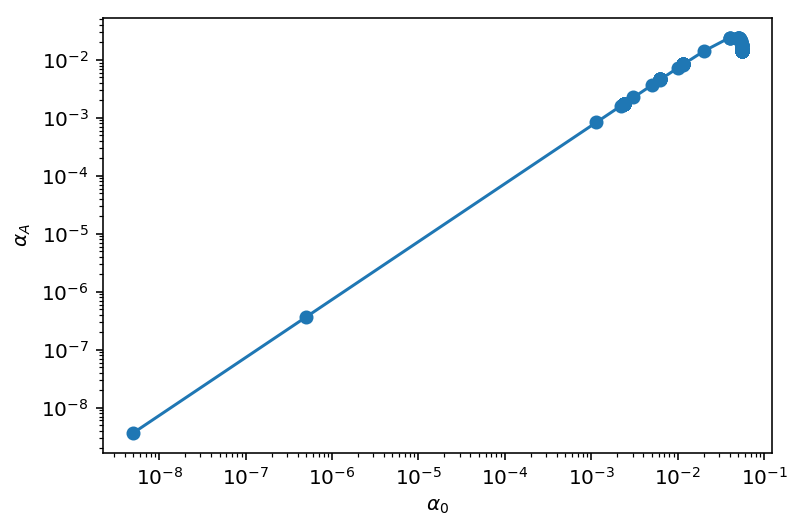

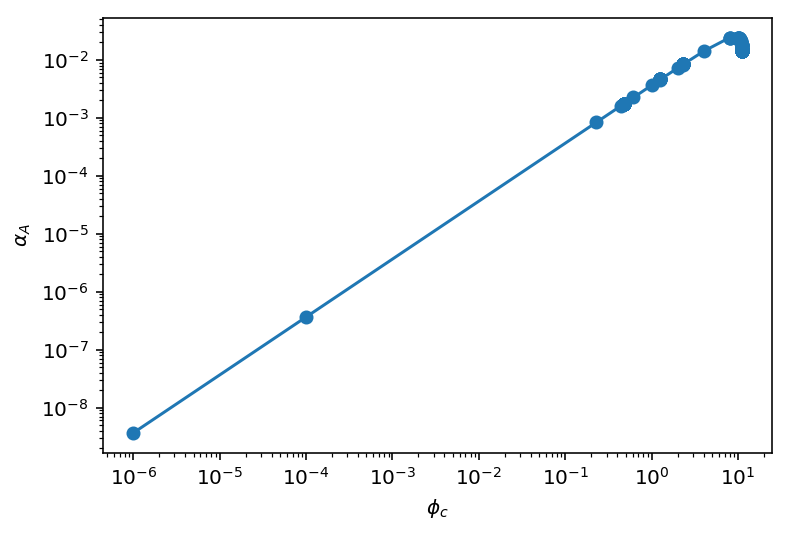

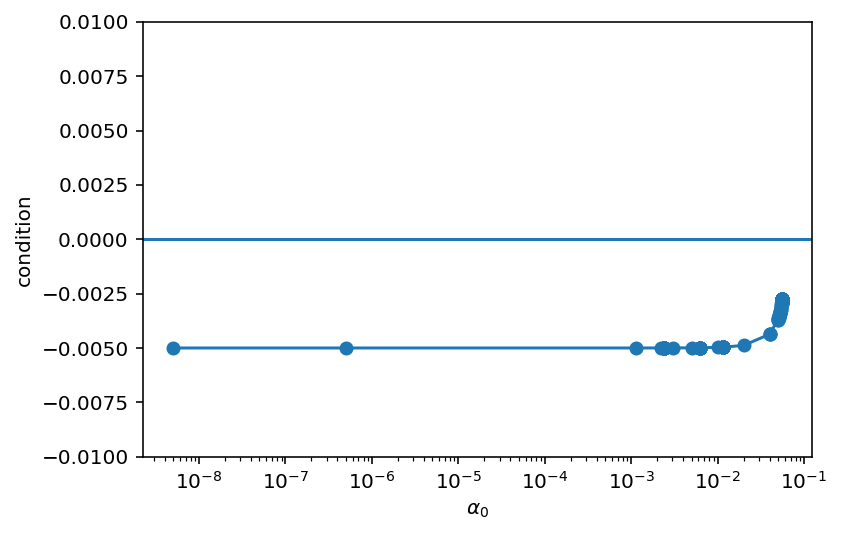

In [851]:
plt.loglog([abs(d["alpha_0"]) for d in ds if d["initial"][1]>phi_c_min],
           [abs(d["alpha_A"]) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
#plt.axhline(1.6e-6)
plt.figure()
plt.loglog([abs(d["initial"][1]-phi_c_min) for d in ds if d["initial"][1]>phi_c_min],
           [abs(d["alpha_A"]) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.xlabel(r"$\phi_c$")
plt.ylabel(r"$\alpha_A$")
#plt.axhline(1.6e-6)
plt.figure()

plt.semilogx([abs(d["alpha_0"]) for d in ds if d["initial"][1]>phi_c_min],
           [condition(d) for d in ds if d["initial"][1]>phi_c_min],
           "o-")
plt.axhline(0)
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"condition")
plt.ylim(-0.01,0.01)

## Checking the constraint behaviour

In [340]:
mass = mass_0348
beta = -5

if beta not in all_map:
    all_map[beta] = {}
alpha_map = all_map[beta]

phis = []
alpha_0s = []
alpha_As = []

for phi_c in sorted(alpha_map):
    print(phi_c)
    d = eos_integrate.mr_curve(alpha_map[phi_c], phi_c, beta, mass) 
    phis.append(phi_c)
    alpha_0s.append(d["alpha_0"])
    alpha_As.append(d["alpha_A"])
    
phis = np.array(phis)
alpha_0s = np.array(alpha_0s)
alpha_As = np.array(alpha_As)

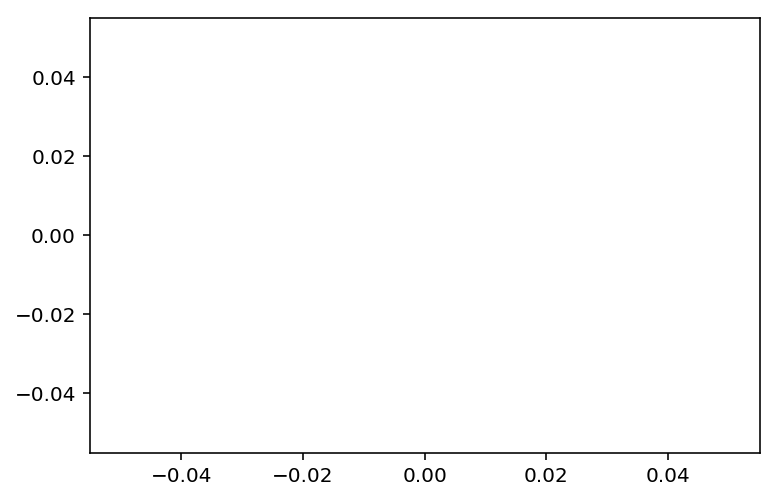

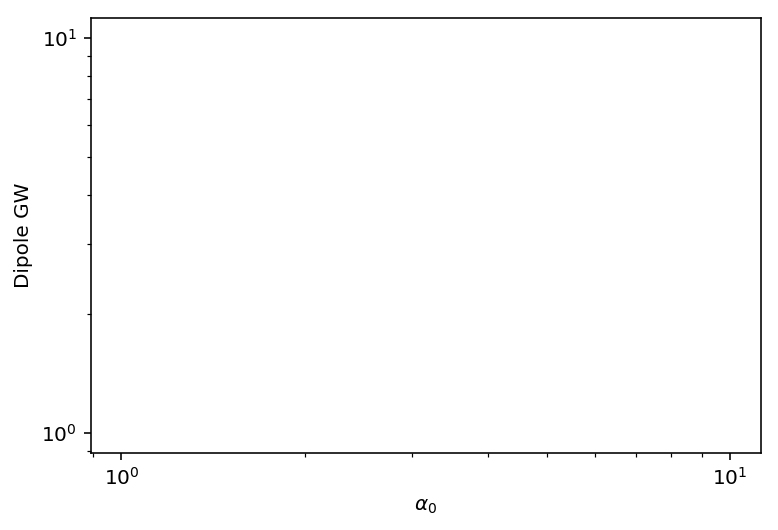

In [341]:
plt.plot(phis, alpha_0s)
plt.plot(phis, alpha_As)
plt.figure()
plt.loglog(alpha_0s, np.abs(alpha_As-alpha_0s))
plt.xlabel(r"$\alpha_0$")
plt.ylabel("Dipole GW")

In [447]:
phi_c = 0.2e-3
beta = -5
mr = []
d = eos_integrate.mr_curve(mr, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(0.00010415328624231039, 0.0004256220413308578)

In [504]:
phi_c = 0.5
beta = -5
mr2 = []
d = eos_integrate.mr_curve(mr2, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(1.2325626474920834, 1.2785514074907005)

In [464]:
phi_c = 8e-2
beta = -1
mr3 = []
d = eos_integrate.mr_curve(mr3, phi_c, beta, mass)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(0.058344099706410024, 0.044284977965885708)

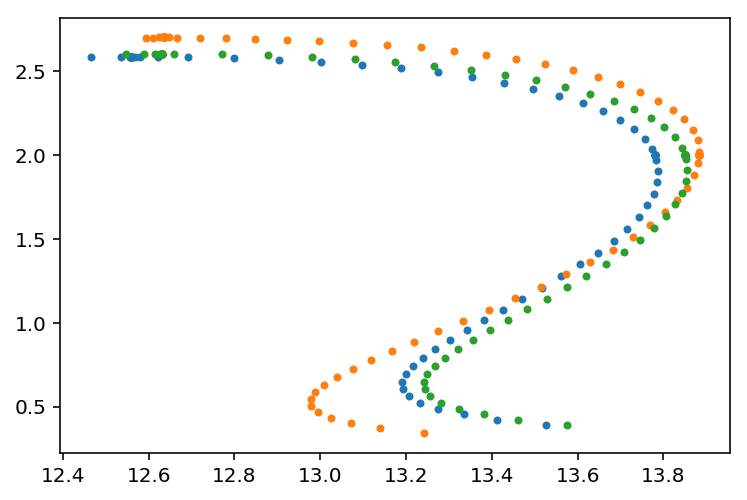

In [465]:
xs = []
ys = []
for pc, d in mr:
    xs.append(d["R"])
    ys.append(d["m_A"])
xs2 = []
ys2 = []
for pc, d in mr2:
    xs2.append(d["R"])
    ys2.append(d["m_A"])
xs3 = []
ys3 = []
for pc, d in mr3:
    xs3.append(d["R"])
    ys3.append(d["m_A"])
plt.plot(xs, ys, ".")
plt.plot(xs2, ys2, ".")
plt.plot(xs3, ys3, ".")


In [367]:
# Figure 4 of 0348 paper
beta = -5

if beta not in all_map:
    all_map[beta] = {}
alpha_map = all_map[beta]

ms = np.linspace(0.4,2.4,10)
alpha_As = []
for m in ms:
    print("Evaluating",m)
    d = eos_integrate.explore_alpha(alpha_map, beta, m, 
                                    lambda d: -d["alpha_0"]-1e-4)
    alpha_As.append(d["alpha_A"])
alpha_As = np.array(alpha_As)

Evaluating 0.4
1.953125e-06 -9.45729679921e-05
Starting search
1.953125e-06 -9.45729679921e-05
Bisection searching
0.000201776697526 0.000460664914505
7.41742480885e-05 0.000106103567507
3.5987023067e-05 -5.00178829103e-09
5.01204304013e-05 3.92666504657e-05
3.59888235082e-05 9.15227434312e-13
bisection found 3.5987023067e-05 3.59888235082e-05
3.59888235082e-05 9.15227434312e-13
Bracketing done 3.5987023067e-05 3.59888235082e-05
3.5987023067e-05 -5.00178829103e-09
3.59888235082e-05 9.15227434312e-13
3.5987023067e-05 -5.00178829103e-09
3.59888235082e-05 9.15227434312e-13
Evaluating 0.622222222222
1.953125e-06 -9.61031361779e-05
Starting search
1.953125e-06 -9.61031361779e-05
Bisection searching
0.000201776697526 0.000302583786848
7.41742480885e-05 4.79920428214e-05
3.5987023067e-05 -2.81988950205e-05
5.01204304013e-05 -1.64853699268e-13
5.01229374228e-05 5.00190440998e-09
bisection found 5.01204304013e-05 5.01229374228e-05
5.01229374228e-05 5.00190440998e-09
Bracketing done 5.0120430401

AlphaProblem: Integration problems prevent condition being met

In [ ]:
plt.plot(ms, alpha_As)

## Spontaneous scalarization, where is it?

In [492]:
phi_c = 1
beta = -5
mr = []
d = eos_integrate.mr_curve(mr, phi_c, beta, mass_0348)
np.abs(d["alpha_0"]) ,np.abs(d["alpha_A"])

(4.7520576398969165, 4.1006113194158447)

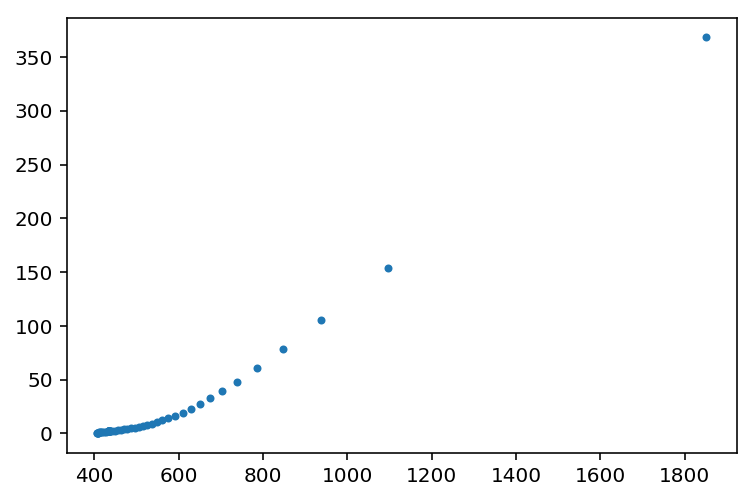

In [493]:
xs = []
ys = []
for pc, d in mr:
    xs.append(d["R"])
    ys.append(d["m_A"])
plt.plot(xs, ys, ".")

In [494]:
p_c, phi_c, beta = d["initial"]
N = eos_integrate.NeutronStar(a=0, b=beta)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T
A_phi = np.array([N.A(phii) for phii in phi])
e = np.array([N.energy_density(pi) for pi in p])
a_phi = N.a + N.b*phi

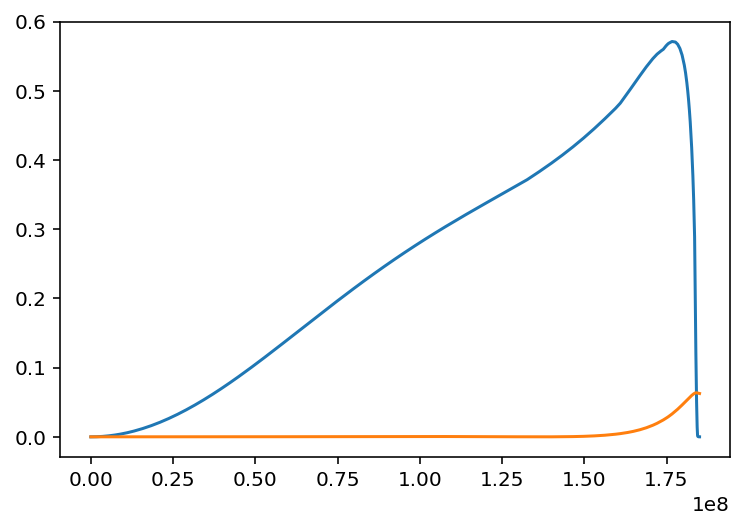

In [495]:
# M_prime terms
plt.plot(rs, (4*np.pi*eos_integrate.G/eos_integrate.c**4*rs**2
              *A_phi**4*e))                                                                    
plt.plot(rs, rs*(rs-2*M)*psi**2/2)


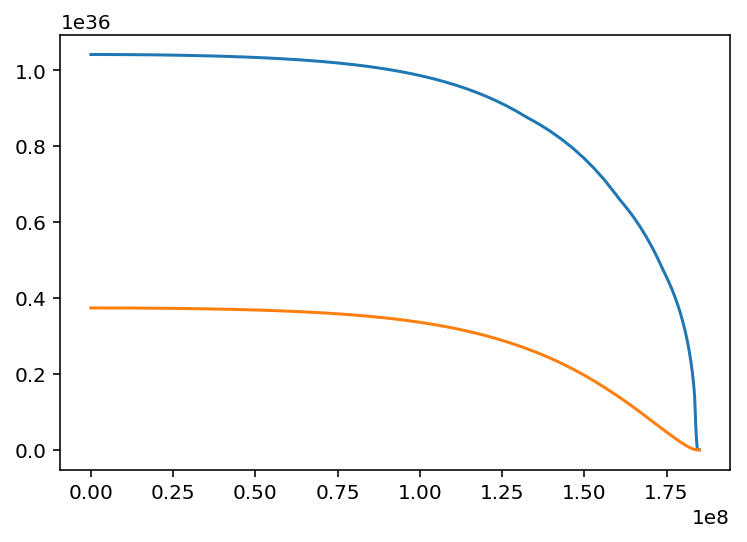

In [496]:
plt.plot(rs, e)
plt.plot(rs, p)

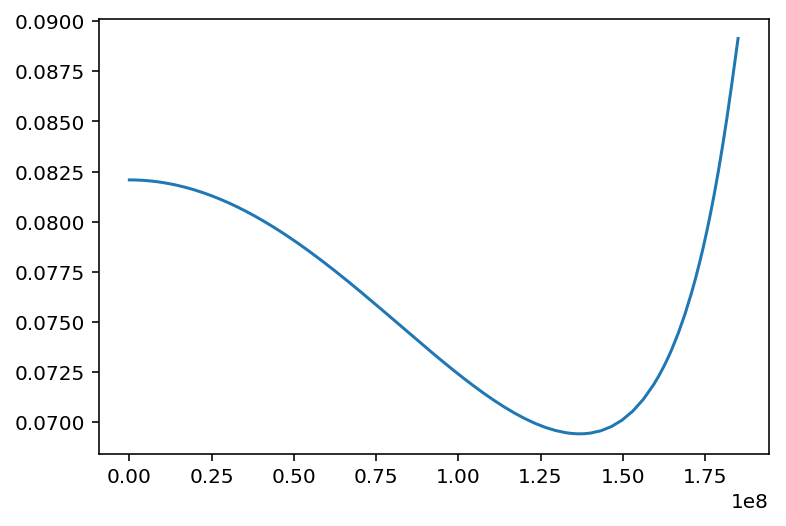

In [497]:
plt.plot(rs, A_phi)

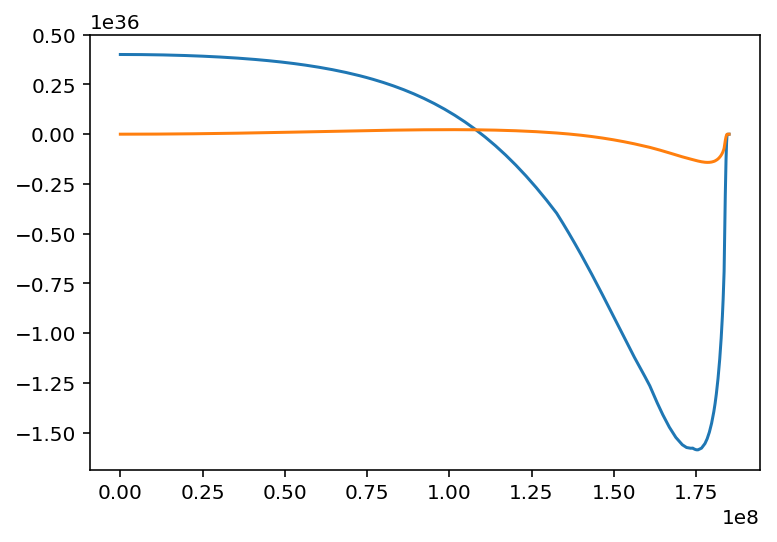

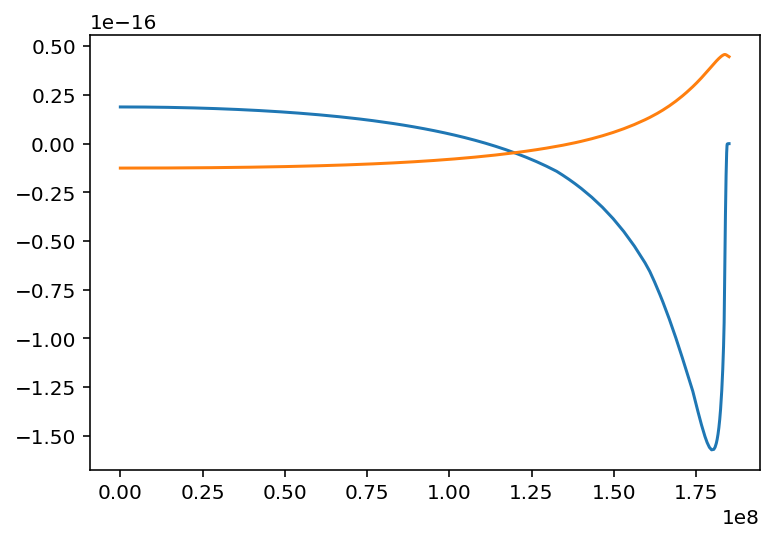

In [498]:
# psi_prime terms
plt.plot(rs, a_phi*(e-3*p))
plt.plot(rs, rs*psi*(e-p))
plt.figure()
plt.plot(rs, 4*np.pi*eos_integrate.G/eos_integrate.c**4
             * rs*A_phi**4/(rs-2*M)
             * (a_phi*(e-3*p)+rs*psi*(e-p)))
plt.plot(rs, - 2*(rs-M)*psi/(rs*(rs-2*M)))

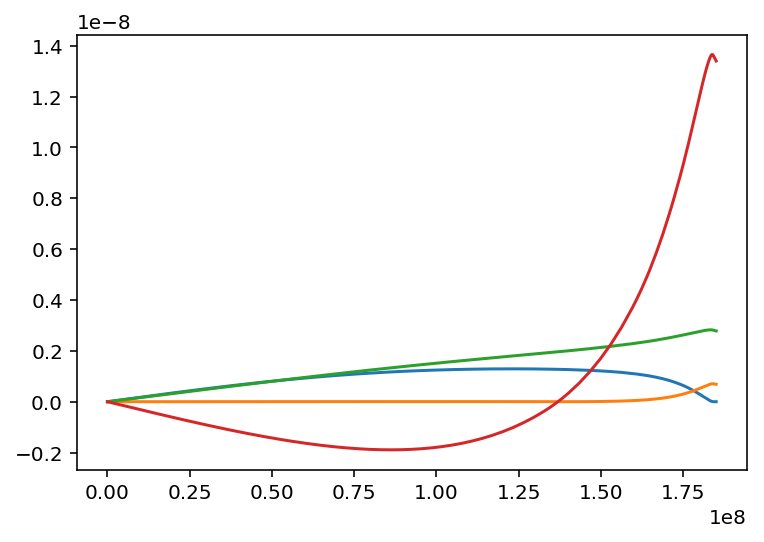

In [499]:
# p terms
plt.plot(rs, 4*np.pi*eos_integrate.G/eos_integrate.c**4
             *rs**2*A_phi**4*p/(rs-2*M))
plt.plot(rs, rs*psi**2/2)
plt.plot(rs, M/(rs*(rs-2*M)))
plt.plot(rs, a_phi*psi)
        

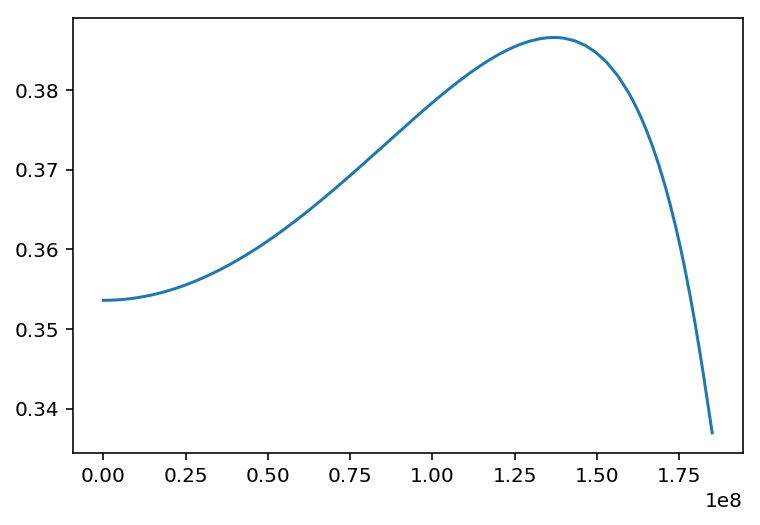

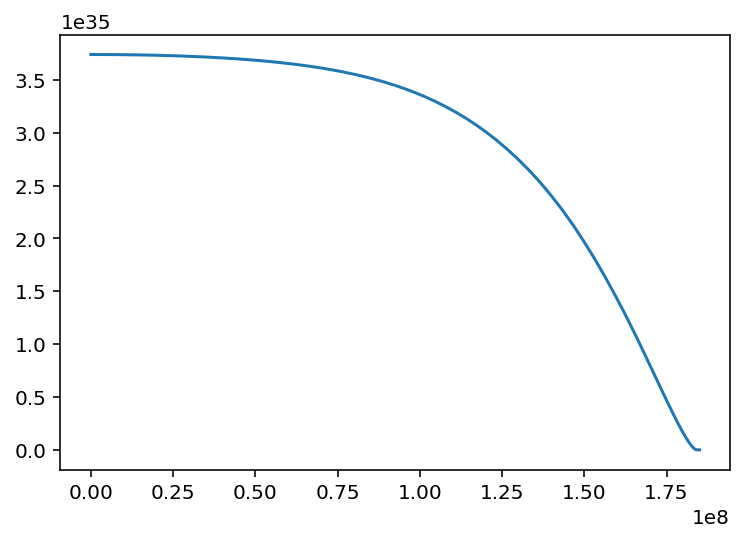

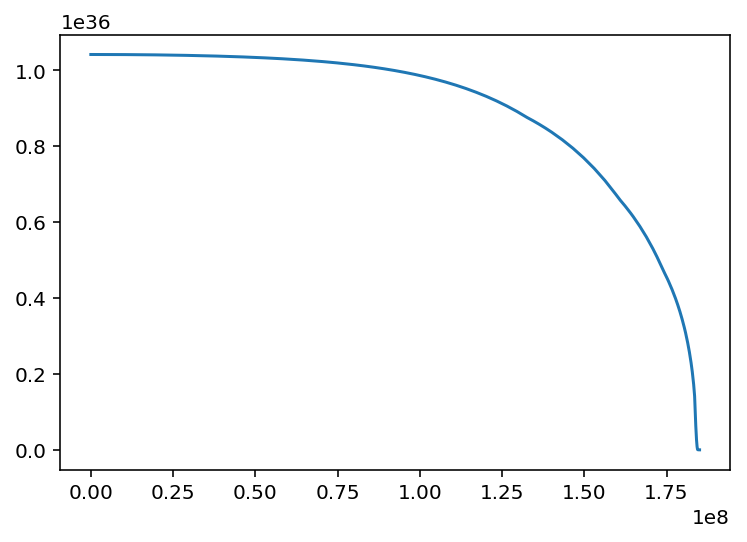

In [500]:
plt.plot(rs, phi-N.phi_0)
plt.figure()
plt.plot(rs, p)
plt.figure()
plt.plot(rs, [N.energy_density(pi) for pi in p])

In [501]:
p_c, phi_c, beta = d["initial"]
N = eos_integrate.NeutronStar(a=0, b=beta)
rs, xs = N.integrate(p_c = p_c, phi_c = phi_c)
rs = np.array(rs)
xs = np.array(xs)
M, nu, phi, psi, p, Mb, omega, omicron = xs.T

N2 = eos_integrate.NeutronStar(a=0, b=beta)
rs2, xs2 = N2.integrate(p_c = p_c, phi_c = 0.4)
rs2 = np.array(rs2)
xs2 = np.array(xs2)
M2, nu2, phi2, psi2, p2, Mb2, omega2, omicron2 = xs2.T

phi_c

1

-5

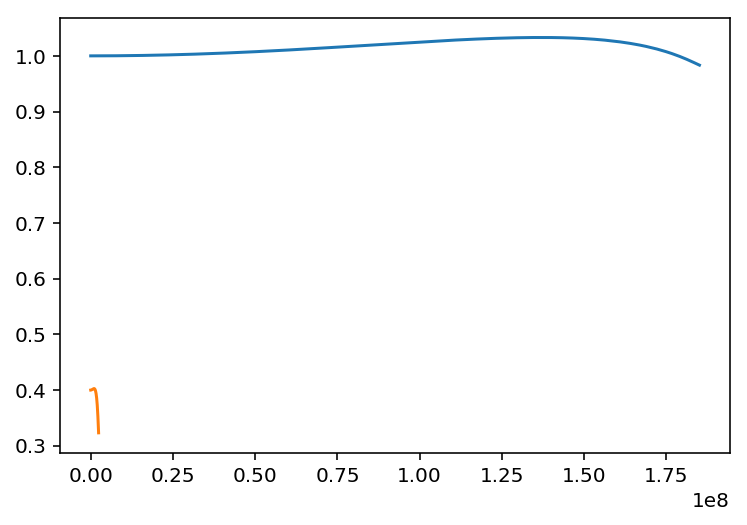

In [502]:
plt.plot(rs, phi)
plt.plot(rs2, phi2)
beta

In [441]:
rs[-1]-rs[-2]

0.0

In [444]:
# Figure 1 of de96
dd = eos_integrate.evaluate(p_c,phi_c,beta)
dd["phi_0"], dd["alpha_0"], dd["alpha_A"]

(-0.0048155617554606345, 0.024077808777303172, -0.10665665069520933)

In [552]:
phi_cs = np.exp(np.linspace(np.log(1e-1),np.log(1),40))
ds = [eos_integrate.mr_curve([],phi_c,-6, mass_0348) 
      for phi_c in phi_cs]

(2, 3)

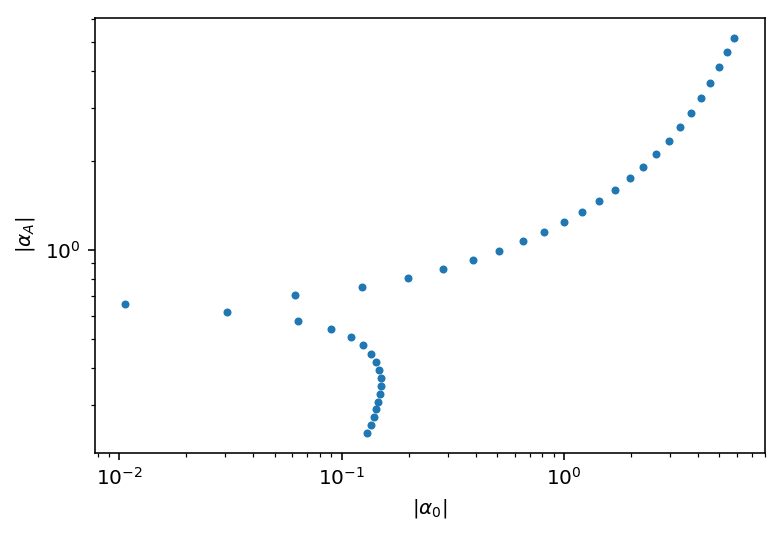

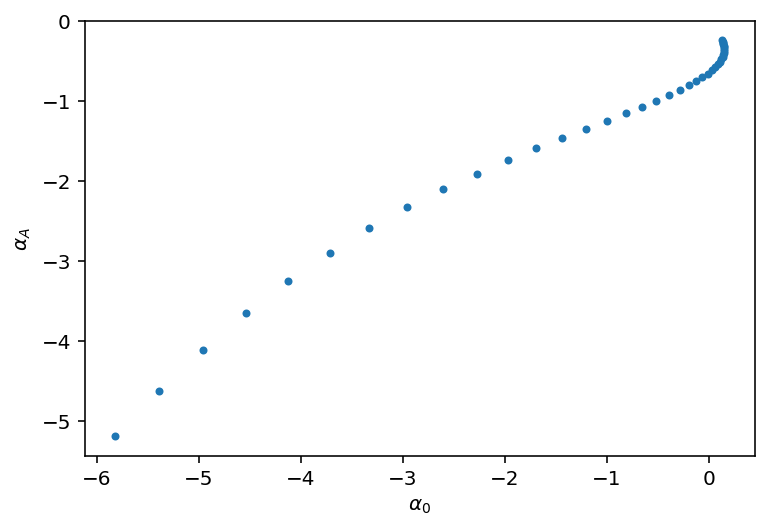

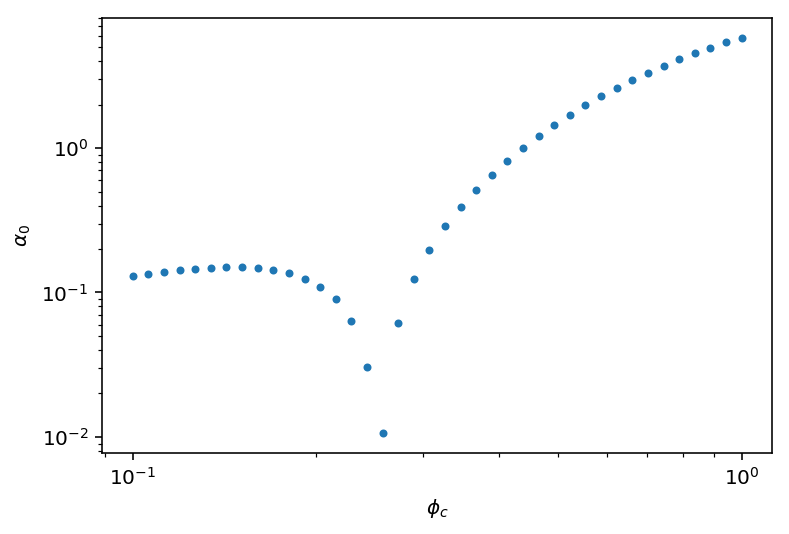

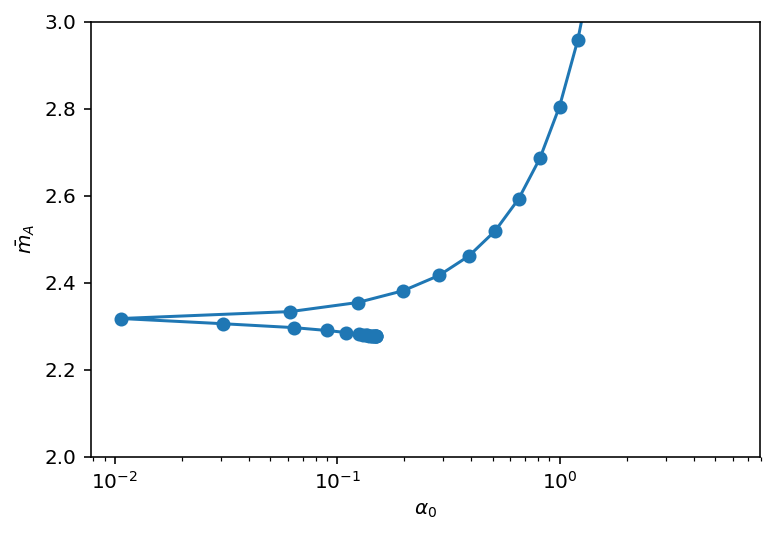

In [554]:
plt.loglog([abs(d["alpha_0"]) for d in ds],
         [abs(d["alpha_A"]) for d in ds], ".")
plt.xlabel(r"$|\alpha_0|$")
plt.ylabel(r"$|\alpha_A|$")
plt.figure()
plt.plot([(d["alpha_0"]) for d in ds],
         [(d["alpha_A"]) for d in ds], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
plt.figure()
plt.loglog(phi_cs,
           [abs(d["alpha_0"]) for d in ds], ".")
plt.xlabel(r"$\phi_c$")
plt.ylabel(r"$\alpha_0$")
plt.figure()
plt.semilogx([abs(d["alpha_0"]) for d in ds],
         [abs(d["mb_A"]) for d in ds], "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\bar m_A$")
plt.ylim(2,3)

In [522]:
pickle.dump?

In [521]:
import pickle

## Exploring where spontaneous scalarization occurs

In [622]:
all_map = {}

In [642]:
beta = -1
mass = mass_0348

if beta not in all_map:
    all_map[beta] = {}
scalar_phi = eos_integrate.find_scalarization(all_map[beta], beta, mass)

0.0001 -7.28637489627e-05
1 -0.852302302118


In [643]:
mass = mass_0337
condition = condition_0337
scalar_phi = eos_integrate.find_scalarization(all_map[beta], beta, mass)
d = eos_integrate.explore_alpha(all_map[beta], beta, mass, condition)
d

0.0001 -7.6515575198e-05
1 -0.880694515618
0.0001 -7.6515575198e-05
1 -0.880694515618
0 condition: -1.6e-06
1 condition: 0.0858074956864
0 condition: -1.6e-06
1 condition: 0.0858074956864
0.0001 condition: -1.59938404927e-06
0.0001 condition: -1.59938404927e-06
1 condition: 0.0858074956864
brentq with 0.0001 -1.59938404927e-06 1 0.0858074956864
0.0001 condition: -1.59938404927e-06
1.0 condition: 0.0858074956864
0.00011863700007 condition: -1.5991330655e-06
0.118861325273 condition: 0.000873957138593
0.000335510963802 condition: -1.5930663895e-06
0.0571814664625 condition: 0.000200080460905
0.000784550469875 condition: -1.56208702574e-06
0.0232512762883 condition: 3.17074215119e-05
0.00183941970163 condition: -1.39159493558e-06
0.0100875035443 condition: 4.66804999428e-06
0.00373358872252 condition: -7.41378818088e-07
0.00559732844395 condition: 3.29805110985e-07
0.00502350459448 condition: -4.55944146317e-08
0.00509319877556 condition: -2.16435968394e-09
0.0050966493771 condition: 1.43

{'Delta': -1.6000014313110808e-06,
 'I_A': 5.5548773491536225e+37,
 'J_A': 5.554877433041515e+37,
 'Omega': 1.0000000151016641,
 'Q1': 1.0000060881758677,
 'Q2': 0.83036484641709329,
 'R': 13.657143568676775,
 'a': 0,
 'alpha_0': -0.0038997512184057418,
 'alpha_A': -0.0034894682691346398,
 'b': -1,
 'beta_0': -1,
 'initial': (6.269867580732077e+34, 0.005096649377103543, -1),
 'm_A': 1.4378000000507549,
 'mb_A': 1.5757733448171813,
 'nu_hat': -0.37178067969001799,
 'nu_prime': 3.2972838316543817e-07,
 'phi_0': 0.0038997512184057418,
 'rho_start': 1e-06}

In [644]:
alpha_map = all_map[beta]
ds = []
for phi_c in sorted(alpha_map.keys()):
    try:
        ds.append(eos_integrate.mr_curve(alpha_map[phi_c], phi_c, beta, mass))
    except eos_integrate.EOSError:
        pass

-1

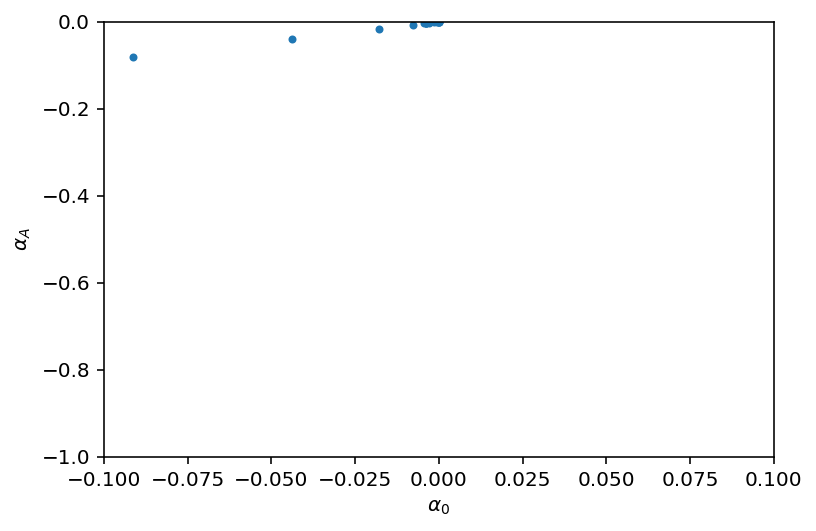

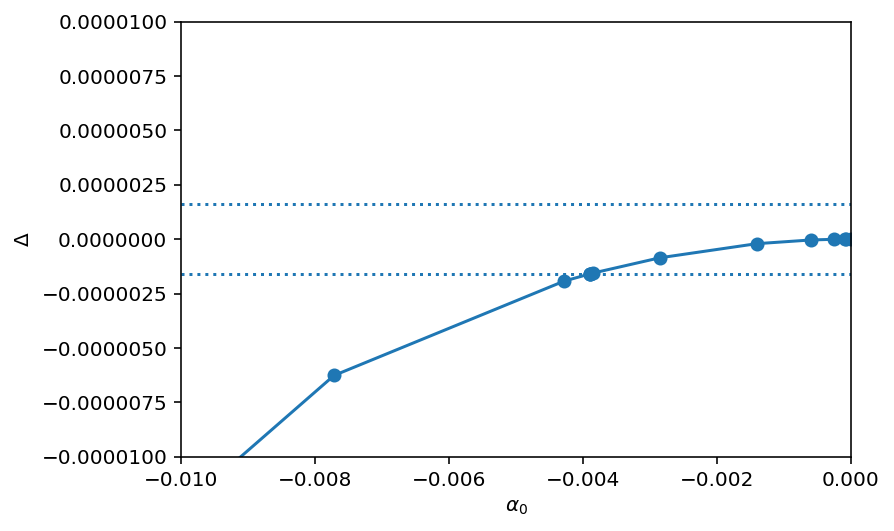

In [649]:
plt.plot([(d["alpha_0"]) for d in ds if d["initial"][1]>=scalar_phi],
         [(d["alpha_A"]) for d in ds if d["initial"][1]>=scalar_phi], ".")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_A$")
plt.xlim(-0.1,0.1)
plt.ylim(-1,0)
plt.figure()
plt.plot([(d["alpha_0"]) for d in ds if d["initial"][1]>=scalar_phi],
         [(d["Delta"]) for d in ds if d["initial"][1]>=scalar_phi], 
         "o-")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\Delta$")
plt.axhline(1.6e-6,linestyle=":")
plt.axhline(-1.6e-6,linestyle=":")
plt.ylim(-1e-5,1e-5)
plt.xlim(-1e-2,0)
beta

In [646]:
beta

-1

In [647]:
scalar_phi

0

In [648]:
d

{'Delta': -0.085809095686351242,
 'I_A': -1.1034227274560479e+40,
 'J_A': -1.103422583827089e+40,
 'Omega': 0.99999986983324218,
 'Q1': 1.2702353772323556,
 'Q2': 0.92218447183186658,
 'R': 27.625395447972895,
 'a': 0,
 'alpha_0': -0.88069451561757184,
 'alpha_A': -0.78326107625275521,
 'b': -1,
 'beta_0': -1,
 'initial': (3.4527346740628564e+34, 1, -1),
 'm_A': 1.4377999999539155,
 'mb_A': 2.2897787643016803,
 'nu_hat': -0.16651543307788805,
 'nu_prime': 6.5484338332231337e-08,
 'phi_0': 0.88069451561757184,
 'rho_start': 1e-06}